# Loading wikipedia bios

## loading raw identities

In [27]:
import pandas as pd
from ast import literal_eval


df = pd.read_csv('FinalDataFrame5.csv')
df.identities = df.identities.apply(literal_eval)
bios = list(df['identities'])

bios[:5]

[['rapper'],
 ['minister', 'Bible scholar', 'author'],
 ['astrophysicist'],
 ['snooker', 'billiards player'],
 ['Welsh sports journalist']]

In [10]:
pd.set_option("max_colwidth", None)
df.iloc[1:2]

,name_searched,context,identities
1,Renita J. Weems,"Renita J. Weems is an ordained minister, a Hebrew Bible scholar, and an author.","[minister, Bible scholar, author]"


In [ ]:
# The rest is similar to twitter bios approach

# Loading twitter bios

## load all raw data

In [31]:
import pickle
with open('/user/smadani/navid/data/pis2020.pkl', 'rb') as f:
    bios = pickle.load(f)
    

# PI frequency and top PIs

In [32]:
from collections import Counter
cntr = Counter()

for bio in bios:
    cntr.update(bio)

print(len(bios))

15459872


In [12]:
import numpy as np

freqs = list(cntr.values())
print(f"percentile freq: {np.percentile(freqs, 90)} mean freq: {np.mean(freqs)}")

percentile freq: 9.0 mean freq: 28.606337144830846


In [14]:
most_frequent_pis = {k:v for k,v in cntr.items() if v > 10}
len(most_frequent_pis)

5106

In [115]:
import pandas as pd

df = pd.DataFrame({'pi': list(most_frequent_pis.keys()), 'cnt': list(most_frequent_pis.values())})
df = df.sort_values(by=['cnt'], ascending=False)

In [116]:
df.to_csv('wiki_most_frequent_pis.csv', index=False, header=True)

In [118]:
!head twitter_most_frequent_pis.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
pi,cnt
she,452418
her,397756
he,185793
him,154092
they,127571
fan account,124627
blacklivesmatter,101217
blm,101082
ig,93961


### most frequent neighbors

In [ ]:
from tqdm import tqdm
neighbor_cnt = {}

for bio in tqdm(bios):
    for pi in bio:
        if pi in most_frequent_pis:
            if pi not in neighbor_cnt:
                neighbor_cnt[pi] = Counter()
                
            rest = [b for b in bio if b!=pi and b in most_frequent_pis]
            neighbor_cnt[pi].update(rest)

print(len(neighbor_cnt))            

#post processing and pruning empty adjacencies

for pi, adj in neighbor_cnt.copy().items():
    if len(adj) < 2:
        neighbor_cnt.pop(pi)
    
print(f"size after pruning: {len(neighbor_cnt)}")        

### calculating tf-idf

In [ ]:
for pi, neighs in tqdm(neighbor_cnt.items()):
    for phrase in neighs.keys():
        neighs[phrase] /= most_frequent_pis[phrase]
        

### calculating using bi-partite method

In [ ]:
from scipy import sparse, io

pi_idx = {}
for pi in most_frequent_pis:
    pi_idx[pi] = len(pi_idx)

#creating bipartite matrix
usr_pi = []

for bio in bios:
    cur_usr_pis = []
    for pi in bio:
        if pi in most_frequent_pis:
            cur_usr_pis.append(pi_idx[pi])
    if len(cur_usr_pis) < 2:
        continue
    usr_pi.append(cur_usr_pis)
    

print(f"original users: {len(bios)}")
print(f"no of users after pruning: {len(usr_pi)}")


In [ ]:
usrs = []
pis = []
scores = []

for uid, pis in enumerate(usr_pi):
    for pi in pis:
        usrs.append(uid)
        pis.append(pi)
        scores.append(1)

In [ ]:
%% time

BP_MATRIX_FILENAME = "./bipartite_pi.mtx"
output_matrix = sparse.coo_matrix((scores, (usrs, pis)))
io.mmwrite(BP_MATRIX_FILENAME, output_matrix)

In [ ]:
!du -hs ./bipartite_pi.mtx

In [ ]:
from scipy import io

io.mmread(BP_MATRIX_FILENAME, output_matrix)

In [ ]:
scores

In [ ]:
!rm ./bipartite_pi.mtx.gz
!gzip ./bipartite_pi.mtx
!ls

In [ ]:
import sys

sys.path.append("../bipartite-pairs/python-scoring/")
import score_data

BP_SCORING_OUTPUT = './bipartite_output.csv.gz'
score_data.score_only(
    BP_MATRIX_FILENAME+".gz",
    ['weighted_corr_exp'],
    BP_SCORING_OUTPUT,
)

In [ ]:
!zcat ./bipartite_output.csv.gz

In [ ]:
import pandas as pd

BP_SCORING_OUTPUT = './bipartite_output.csv.gz'
df = pd.read_csv(BP_SCORING_OUTPUT)
df.head()

In [ ]:
# recreate the neighboring dictionary



### save 

In [ ]:
import pandas as pd

pis = []
positives = []
negatives = []

for pi, cntr in tqdm(neighbor_cnt.items()):
    cur_neg = [x for x in most_frequent_pis if x not in neighbor_cnt[pi]]
    if len(cur_neg) > 20:
        cur_neg = list(np.random.choice(cur_neg, size=20, replace=False))
    cur_pos = [x[0] for x in neighbor_cnt[pi].most_common(5)]
    if len(cur_neg) < 4 or len(neighbor_cnt[pi])<2:
        print(f"PASSING PI: {pi}")
        continue
    positives.append(cur_pos)
    pis.append(pi)
    negatives.append(cur_neg)
                 
print(f"saving {len(pis)} pis")
df = pd.DataFrame({'pis': pis, 'positives': positives, 'negatives': negatives})
df.to_csv('twitter_pi_with_neighbors_tfidf.csv', index=False, header=True)

In [ ]:
!wc -l wiki_pi_with_neighbors_standard.csv

In [ ]:
!head wiki_pi_with_neighbors_standard.csv

## create train and test dataset

In [33]:
from sklearn.model_selection import train_test_split

lower_bios = []
for bio in bios:
    lower_bio = []
    for pi in bio:
        lower_bio.append(pi.lower())
    lower_bios.append(lower_bio)
    
train, test = train_test_split(lower_bios, test_size=0.2, shuffle=True)
print(len(train), len(test))



12367897 3091975


In [34]:
import pickle

dataset = 'twitter'

with open(f'./data/{dataset}_test_bios.pkl', 'wb') as f:
    pickle.dump(test, f)
    
with open(f'./data/{dataset}_train_bios.pkl', 'wb') as f:
    pickle.dump(train, f)

In [1]:
import pickle

dataset = 'twitter'

with open(f'./data/{dataset}_test_bios.pkl', 'rb') as f:
    test = pickle.load(f)
    
test[:5]

[['writer',
  'reader',
  'gamer',
  'wolverine',
  'marine',
  'music buff',
  'son',
  'brother',
  'fiance'],
 ['whatever will be', 'will be', 'm20'],
 ['shtwt', 'she', 'her', '10 days clean', 'bts', 'txt', 'babymetal stan'],
 ['lix official twitter'],
 []]

# Cleaning data

## phrase cleaning

In [8]:
import pickle

dataset = 'wiki'
min_freq = 3 if dataset == 'wiki' else 100

print(min_freq)
with open(f'./data/{dataset}_train_bios.pkl', 'rb') as f:
    bios = pickle.load(f)

3


In [9]:
# build a vocabulary of phrases
from tqdm import tqdm_notebook as tqdm
from collections import Counter

pi_cnt = Counter()
for bio in tqdm(bios):
    pi_cnt.update(bio)

len(pi_cnt)

/scratch/12746311/ipykernel_2043/2665102249.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bio in tqdm(bios):


  0%|          | 0/788343 [00:00<?, ?it/s]

44484

In [10]:
pi_cnt.most_common(10)

[('footballer', 87629),
 ('politician', 59687),
 ('actor', 24498),
 ('actress', 22208),
 ('writer', 20656),
 ('professor', 19977),
 ('author', 19583),
 ('member', 19326),
 ('football player', 17436),
 ('singer', 16542)]

In [11]:
pi_cnt.most_common(len(pi_cnt))[-5:]

[('lokoja', 1),
 ('usa pageant', 1),
 ('state coroner', 1),
 ('trinidad soccer', 1),
 ('film technician', 1)]

## cleaning each bio

In [12]:
from tqdm import tqdm

# phrases of lenght at least m
# profiles with at least k phrases
# pis that's been repeated at least m times in dataset

def clean_pis(all_pis):
    result = []
    for pis in tqdm(all_pis):
        current_pi = set()
        for pi in pis:
            if len(pi) >= 2 and pi_cnt[pi] >= min_freq:
                current_pi.add(pi)
        if len(current_pi) > 1:
            result.append(list(current_pi))
            
    return result
            
cleaned_bios = clean_pis(bios)
print(len(cleaned_bios), len(bios))

100%|██████████| 788343/788343 [00:00<00:00, 1124472.31it/s]

239046 788343


## saving cleaned dataset

In [13]:
with open(f'./data/{dataset}_cleaned_train_bios_{min_freq}.pkl', 'wb') as f:
    pickle.dump(cleaned_bios, f)

# Masked Language Modeling

## loading dataset

In [14]:
import pickle
import numpy as np

dataset = 'wiki'
freq = 3
    
with open(f'./data/{dataset}_cleaned_train_bios_{freq}.pkl', 'rb') as f:
    bios = pickle.load(f)
    
pi_set = set()
for bio in bios:
    pi_set.update(bio)
pi_set = list(pi_set)
    
len(bios), len(pi_set)

(239046, 11074)

## cleaning dataset for full bio

In [2]:
from tqdm import tqdm
import re

## remove url and email addresses + social media links
cleaned_bios = []

for description in tqdm(bios):
    d = re.sub(r'\w+@\w+\.\w+', '', description.lower()).strip()
    d = re.sub(r'(on )?(snapchat|snap|ig|insta|instagram|email|phone): +[A-Za-z0-9_@.-]+', " ", d).strip()
    d = re.sub(r'http\S+', '', d).strip()
    d = d.replace("&emsp;", "").replace("&nbsp;", "")
    d = re.sub(r"\s+", " ", d).strip()
    if len(d) > 5:
        cleaned_bios.append(d)

len(cleaned_bios), cleaned_bios[:10]

100%|██████████| 16240577/16240577 [04:33<00:00, 59397.68it/s]


(15646051,
 ['doer, maker, photo-taker. words: bff.fm radio dj:',
  'i like to build things (@foursquare📱, @stockadefc ⚽️ @streetfc, dodgeball 📟) husband to @chelsa, dad to 👧🏼❄️ & 👶🏼🚀. i enjoy snowboards, soccer & hot dogs',
  'product and design leader. formerly @getfandom, @ign, and @yahoo. i build great teams that build great products.',
  'founder at @hellofahren.com. previously: led @gokartlabs, digital mktg at genmills, ameriprise, amex. dad, biker, guitaristcreate more, consume less',
  'compassionate technocrat. connector and instigator.',
  'only human. ceo of @visualisgood ❤️ past lives in public media, journalism, vlogging. #blacklivesmatter',
  'would punch a nazi. anti-racist. anti-fascist. #fucktrump #ftp',
  'mother. designer. coder. writer. singer. complete geek. 296.89. my opinions are my own, and not any other persons, or my employer. she/her',
  'tweeting about startups and product design/development. ceo @todesktop. yc w20.',
  'redacteur trends magazine, retail & t

## save train and test datasets

### convert to pytorch dataset

In [15]:

from datasets import Dataset
import pandas as pd

train_df = pd.DataFrame([{'bios': ", ".join(t)} for t in bios])
train_dataset = Dataset.from_pandas(train_df)



In [16]:
from datasets import DatasetDict

dataset_name = 'wiki'

train_dataset.save_to_disk(f'./data/{dataset_name}_hf_dataset')

In [18]:
!du -hs  ./data/wiki_hf_dataset/

7.1M	./data/wiki_hf_dataset/


## load train and test

In [20]:
from datasets import DatasetDict, Dataset

dataset_name = 'wiki'
dataset = Dataset.load_from_disk(f'./data/{dataset_name}_hf_dataset')

dataset

Dataset({
    features: ['bios'],
    num_rows: 239046
})

## data preprocessing

### load model and tokenizers

In [21]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer


model_checkpoint = "bert-base-uncased"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### test if model

In [22]:
import torch


text = "This is a great [MASK]."


inputs = tokenizer(text, return_tensors="pt")
token_logits = model(**inputs).logits
print(token_logits.shape)
# Find the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
print(mask_token_index)
mask_token_logits = token_logits[0, mask_token_index, :]
# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
    print(f"'>>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}'")

torch.Size([1, 8, 30522])
tensor([5])
'>>> This is a great idea.'
'>>> This is a great day.'
'>>> This is a great place.'
'>>> This is a great time.'
'>>> This is a great thing.'


### preprocessing data

In [23]:
def preprocess(examples):
    result = tokenizer(examples["bios"], padding='max_length', max_length=80, truncation=True)
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    
    result["labels"] = result["input_ids"].copy()
    return result

# for test
# tokenized_datasets2 = dataset.select(range(1000)).map(
#     preprocess, batched=True, batch_size=250, num_proc=1
# )
# tokenized_datasets2

#Use batched=True to activate fast multithreading!
tokenized_datasets = dataset.map(
    preprocess, batched=True, remove_columns=["bios",], batch_size=250, num_proc=10
)
tokenized_datasets

#0:   0%|          | 0/96 [00:00<?, ?ba/s]

#1:   0%|          | 0/96 [00:00<?, ?ba/s]

#2:   0%|          | 0/96 [00:00<?, ?ba/s]

#3:   0%|          | 0/96 [00:00<?, ?ba/s]

#4:   0%|          | 0/96 [00:00<?, ?ba/s]

#5:   0%|          | 0/96 [00:00<?, ?ba/s]

#6:   0%|          | 0/96 [00:00<?, ?ba/s]

#7:   0%|          | 0/96 [00:00<?, ?ba/s]

#8:   0%|          | 0/96 [00:00<?, ?ba/s]

#9:   0%|          | 0/96 [00:00<?, ?ba/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
    num_rows: 239046
})

In [24]:
!rm -rf ./data/twitter_hf_dataset_tokenized/

In [25]:
tokenized_datasets.save_to_disk(f'./data/{dataset_name}_hf_dataset_tokenized')

In [26]:
!du -hs ./data/wiki_hf_dataset_tokenized/

409M	./data/wiki_hf_dataset_tokenized/


In [27]:
from datasets import DatasetDict, Dataset
import torch

dataset_name = 'wiki'
tokenized_datasets = Dataset.load_from_disk(f'./data/{dataset_name}_hf_dataset_tokenized')

tokenized_datasets

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
    num_rows: 239046
})

### masking

In [28]:
import collections
import numpy as np

from transformers import default_data_collator

wwm_probability = 0.33


def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id
        feature["labels"] = new_labels

    return default_data_collator(features)

In [29]:
samples = [tokenized_datasets[i] for i in range(10)]
batch = whole_word_masking_data_collator(samples)

for chunk in batch["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] musician, songwriter, video director [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

'>>> [CLS] story writer [MASK] novelist [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

'>>> [CLS] race [MA

### fine tuning

In [30]:
from transformers import TrainingArguments


downsampled_dataset = tokenized_datasets.train_test_split(
    train_size=int(2e5), test_size=int(3e4), seed=42
)

print(downsampled_dataset)

batch_size = 64
logging_steps = int((len(downsampled_dataset['train']) // batch_size) / 10)

print(f"logging steps: {logging_steps}")

args = TrainingArguments(
    # output_dir: directory where the model checkpoints will be saved.
    output_dir='./models/bert-ft-mlm-wiki',
    overwrite_output_dir=True,
    # evaluation_strategy (default "no"):
    # Possible values are:
    # "no": No evaluation is done during training.
    # "steps": Evaluation is done (and logged) every eval_steps.
    # "epoch": Evaluation is done at the end of each epoch.
    evaluation_strategy="steps",
    # eval_steps: Number of update steps between two evaluations if
    # evaluation_strategy="steps". Will default to the same value as
    # logging_steps if not set.
    eval_steps=logging_steps,
    # logging_strategy (default: "steps"): The logging strategy to adopt during
    # training (used to log training loss for example). Possible values are:
    # "no": No logging is done during training.
    # "epoch": Logging is done at the end of each epoch.
    # "steps": Logging is done every logging_steps.
    logging_strategy="steps",
    # logging_steps (default 500): Number of update steps between two logs if
    # logging_strategy="steps".
    logging_steps=logging_steps,
    # save_strategy (default "steps"):
    # The checkpoint save strategy to adopt during training. Possible values are:
    # "no": No save is done during training.
    # "epoch": Save is done at the end of each epoch.
    # "steps": Save is done every save_steps (default 500).
    save_strategy="steps",
    # save_steps (default: 500): Number of updates steps before two checkpoint
    # saves if save_strategy="steps".
    save_steps=logging_steps,
    # learning_rate (default 5e-5): The initial learning rate for AdamW optimizer.
    # Adam algorithm with weight decay fix as introduced in the paper
    # Decoupled Weight Decay Regularization.
    learning_rate=2e-5,
    # per_device_train_batch_size: The batch size per GPU/TPU core/CPU for training.
    per_device_train_batch_size=batch_size,
    # per_device_eval_batch_size: The batch size per GPU/TPU core/CPU for evaluation.
    per_device_eval_batch_size=batch_size,
    # num_train_epochs (default 3.0): Total number of training epochs to perform
    # (if not an integer, will perform the decimal part percents of the last epoch
    # before stopping training).
    num_train_epochs=20,
    # load_best_model_at_end (default False): Whether or not to load the best model
    # found during training at the end of training.
    load_best_model_at_end=True,
    # metric_for_best_model:
    # Use in conjunction with load_best_model_at_end to specify the metric to use
    # to compare two different models. Must be the name of a metric returned by
    # the evaluation with or without the prefix "eval_".
    metric_for_best_model="loss",
    # report_to:
    # The list of integrations to report the results and logs to. Supported
    # platforms are "azure_ml", "comet_ml", "mlflow", "tensorboard" and "wandb".
    # Use "all" to report to all integrations installed, "none" for no integrations.
    report_to="tensorboard",
    weight_decay=0.01,
    # to avoid removing word_ids
    remove_unused_columns=False
    
)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 200000
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 30000
    })
})
logging steps: 312


In [31]:
from transformers import Trainer


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=downsampled_dataset["train"],
    eval_dataset=downsampled_dataset["test"],
    data_collator=whole_word_masking_data_collator,
)

In [ ]:
trainer.train()

/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 200000
  Num Epochs = 20
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 31260
/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
312,3.032000,2.734608
624,2.728100,2.622533


***** Running Evaluation *****
  Num examples = 30000
  Batch size = 128
Saving model checkpoint to ./models/bert-ft-mlm-wiki/checkpoint-312
Configuration saved in ./models/bert-ft-mlm-wiki/checkpoint-312/config.json
Model weights saved in ./models/bert-ft-mlm-wiki/checkpoint-312/pytorch_model.bin
/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 30000
  Batch size = 128
Saving model checkpoint to ./models/bert-ft-mlm-wiki/checkpoint-624
Configuration saved in ./models/bert-ft-mlm-wiki/checkpoint-624/config.json
Model weights saved in ./models/bert-ft-mlm-wiki/checkpoint-624/pytorch_model.bin
/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/torch/

### evaluate model

In [ ]:
import math

eval_results = trainer.evaluate(tokenized_datasets['valid'])
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

# Contrastive learning

## generating positive negative samples

In [15]:
import pickle
import numpy as np

dataset = 'twitter'
freq = 100
    
with open(f'./data/{dataset}_cleaned_train_bios_{freq}.pkl', 'rb') as f:
    bios = pickle.load(f)
    
pi_set = set()
for bio in bios:
    pi_set.update(bio)
pi_set = list(pi_set)
    
len(bios), len(pi_set)

(3534903, 22516)

In [16]:
np.median([len(x) for x in bios])

3.0

### neighbors of a PI

In [ ]:
from tqdm import tqdm
neighbors = {}
from collections import Counter

for bio in tqdm(bios):
    for pi in bio:
        if pi in pi_set:
            if pi not in neighbors:
                neighbors[pi] = Counter()
                
            rest = [b for b in bio if b!=pi and b in pi_set]
            neighbors[pi].update(rest)

print(len(neighbors))            


 29%|██▉       | 1024029/3534903 [44:38<2:07:01, 329.44it/s]

### pos/neg samples

In [ ]:
from random import randint
import numpy as np

def pair_in_list(current_pair, l):
    for pair in l:
        if current_pair[0] in pair and current_pair[1] in pair:
            return True
    return False


def generate_triplets(bios, k=3):
    samples = []
    for idx, bio in tqdm(enumerate(bios), total=len(bios)):
        if len(bio) != len(set(bio)):
            continue
        iters = min(len(bio)-1, k)
        chosen_pis = []
        for i in range(iters):
            pos1, pos2 = np.random.choice(bio, size=2, replace=False)
            while pair_in_list([pos1,pos2], chosen_pis):
                pos1, pos2 = np.random.choice(bio, size=2, replace=False)
            chosen_pis.append([pos1, pos2])
            neg_idx = randint(0, len(pi_set)-1)
            while pi_set[neg_idx] in neighbors[pos1] or pi_set[neg_idx] in neighbors[pos2]:
                neg_idx = randint(0, len(pi_set)-1)
            samples.append([pos1, pos2, pi_set[neg_idx]])
    return samples

triplets = generate_triplets(bios, k=3)

In [ ]:
print(len(triplets))

## save dataset

In [ ]:
import pickle 

with open(f'data/{dataset}-triplets_{freq}.pkl', 'wb') as f:
    pickle.dump(triplets, f)

In [13]:
import pickle 

dataset = 'twitter'
freq = 100

with open(f'data/{dataset}-triplets_{freq}.pkl', 'rb') as f:
    triplets = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'data/twitter-triplets_100.pkl'

In [29]:
import csv

# writing the data into the file
with open(f'data/{dataset}-valid-{freq}.csv', 'w') as f:   
    write = csv.writer(f, delimiter='\t')
    write.writerows(valid_set)
    
with open(f'data/{dataset}-train-{freq}.csv', 'w') as f:   
    write = csv.writer(f, delimiter='\t')
    write.writerows(train_set)


## finetuning

### building the dataset


In [30]:
import csv
from sentence_transformers import SentenceTransformer, InputExample, losses, util
from torch.utils.data import DataLoader

dataset = 'wiki'
freq=3

with open(f'data/{dataset}-train-{freq}.csv', newline='') as f:
    train_examples = []
    reader = csv.reader(f, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in tqdm(reader):
        train_examples.append(InputExample(texts=[row[0], row[1]], label=1.0))
        train_examples.append(InputExample(texts=[row[0], row[2]], label=0.0))
    

328929it [00:03, 83138.59it/s] 


### loading evaluation dataset

In [31]:

from sentence_transformers import evaluation

with open(f'data/{dataset}-valid-{freq}.csv', newline='') as f:
    sent1s = []
    sent2s = []
    scores = []
    i = 0
    reader = csv.reader(f, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in tqdm(reader):
        sent1s.append(row[0])
        sent1s.append(row[0])
        sent2s.append(row[1])
        sent2s.append(row[2])
        scores.append(1.0)
        scores.append(0.0)
        i += 1
evaluator = evaluation.EmbeddingSimilarityEvaluator(sent1s, sent2s, scores)


36548it [00:00, 641309.21it/s]


### creating data loaders

In [32]:
from sentence_transformers import SentenceTransformer, models
from torch import nn

model_name = 'all-distilroberta-v1'
model = SentenceTransformer(model_name)
# dense_model = models.Dense(in_features=model.get_sentence_embedding_dimension(), out_features=256, activation_function=nn.Tanh())
# model.add_module('3', dense_model)

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=256)
train_loss = losses.CosineSimilarityLoss(model)

model

/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

### training

In [33]:
output_model_path = f'models/distilroberta-{dataset}-freq{freq}'

model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=10,
          evaluation_steps=5000,
          warmup_steps=5000,
          output_path=output_model_path)

/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2570 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2570 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2570 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2570 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2570 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2570 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2570 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2570 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2570 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2570 [00:00<?, ?it/s]

### valiation results - best model


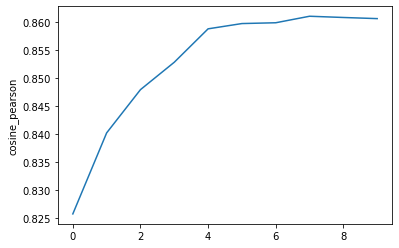

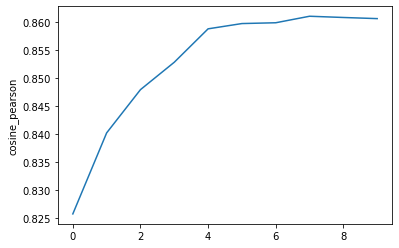

In [34]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

twitter_valid = pd.read_csv(f'models/distilroberta-{dataset}-freq{freq}/eval/similarity_evaluation_results.csv')
wiki_valid = pd.read_csv(f'models/distilroberta-{dataset}-freq{freq}/eval/similarity_evaluation_results.csv')

sns.lineplot(x=range(len(twitter_valid)), y=twitter_valid['cosine_pearson'])
plt.show()
sns.lineplot(x=range(len(wiki_valid)), y=wiki_valid['cosine_pearson'])
plt.show()

## evaluation

### loading saved model

In [ ]:
%env CUDA_VISIBLE_DEVICES=1

In [ ]:
from sentence_transformers import SentenceTransformer, models

model = SentenceTransformer('./models/miniLM-L6-finetuned-wiki/')

model

### calculating encodings for all phrases

In [ ]:
pis = set()

for bio in cleaned_bios:
    pis.update(bio)

pis = list(pis)
print(len(pis))

embeddings = model.encode(pis, convert_to_tensor=True)
        

In [ ]:
def most_similar(pi, all_pis, all_pi_embs, model, k=11):
    cur_emb = model.encode(pi, convert_to_tensor=True)
    cosine_scores = util.cos_sim(cur_emb, all_pi_embs).detach().cpu().numpy()[0]
    most_similars = np.argsort(cosine_scores)[-k:]
    return [(all_pis[i], cosine_scores[i]) for i in most_similars if pi!=all_pis[i]]

most_similar('mima', pis, embeddings, model, k=50)

In [ ]:
def get_similarity(w1, w2, model=model):
    emb1 = model.encode(w1, convert_to_tensor=True)
    emb2 = model.encode(w2, convert_to_tensor=True)
    return util.cos_sim(emb1, emb2)

print(
    get_similarity('isfj', 'man'),
    get_similarity('isfj', 'woman'),
    get_similarity('isfj', 'man', model=model),
    get_similarity('isfj', 'woman', model=model),
)

print(
    get_similarity('intj', 'man'),
    get_similarity('intj', 'woman'),
    get_similarity('intj', 'man', model=model),
    get_similarity('intj', 'woman', model=model),
)

print(
    get_similarity('entj', 'man'),
    get_similarity('entj', 'woman'),
    get_similarity('entj', 'man', model=model),
    get_similarity('entj', 'woman', model=model),
)


In [ ]:
mom_emb = base_model.encode('intp', convert_to_tensor=True)
dad_emb = base_model.encode('esfj', convert_to_tensor=True)
util.cos_sim(mom_emb, dad_emb)

### loading not tuned model and doing the same thing

In [ ]:
from sentence_transformers import SentenceTransformer, models

base_model = SentenceTransformer('all-MiniLM-L6-v2')
base_embs = base_model.encode(pis, convert_to_tensor=True)
base_cosine_scores = util.cos_sim(base_embs, base_embs).detach().cpu().numpy()

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

target_word = 'build the wall'
df1 = pd.DataFrame(most_similar(target_word, pis, embeddings, model), columns=['identifier', 'similarity'])
df1['model'] = 'fine-tuned-sentence-bert'
df2 = pd.DataFrame(most_similar(target_word, pis, base_embs, base_model), columns=['identifier', 'similarity'])
df2['model'] = 'original-sentence-bert'


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

ax1.scatter(x=df1['identifier'], y=df1['similarity'])
ax1.tick_params(axis='x', rotation=-60)
ax1.set_xlabel('phrase')
ax1.set_ylabel('similarity')
ax1.set_title('fine-tuned-sentence-bert')


ax2.scatter(x=df2['identifier'], y=df2['similarity'])
ax2.tick_params(axis='x', rotation=-60)
ax2.set_xlabel('phrase')
ax2.set_ylabel('similarity')
ax2.set_title('original-sentence-bert')

plt.show()

### analyzing personalities

In [ ]:
for personality in ['ESTJ', 'ENTJ', 'ESFJ', 'ENFJ', 'ISTJ', 'ISFJ', 'INTJ', 'INFJ', 'ESTP', 'ESFP', 'ENTP', 'ENFP', 'ISTP', 'ISFP', 'INTP', 'INFP']:
    if personality in pis or personality.lower() in pis:
        print(f"{personality}: True")
    else:
        print(f"{personality}: False")

In [ ]:
personalities = ['ESTJ', 'ENTJ', 'ESFJ', 'ENFJ', 'ISTJ', 'ISFJ', 'INTJ', 'INFJ', 'ESTP', 'ESFP', 'ENTP', 'ENFP', 'ISTP', 'ISFP', 'INTP', 'INFP']
personalities = [p.lower() for p in personalities]

pers_emb = model.encode(personalities, convert_to_tensor=True)
pers_emb_base = base_model.encode(personalities, convert_to_tensor=True)

base_cosine_scores = util.cos_sim(pers_emb_base, pers_emb_base).detach().cpu().numpy()
cosine_scores = util.cos_sim(pers_emb, pers_emb).detach().cpu().numpy()

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(cosine_scores)
ax.set_xticklabels(personalities, rotation=90)
ax.set_yticklabels(personalities, rotation=0)

# plt.xticks(ticks=personalities)
# plt.yticks(ticks=personalities)

In [ ]:
plt.figure(figsize=(10,10))

ax = sns.heatmap(base_cosine_scores)
ax.set_xticklabels(personalities, rotation=90)
ax.set_yticklabels(personalities, rotation=0)

### comparing in gensim vocab

In [ ]:
import gensim.downloader as api

w2v = api.load("glove-wiki-gigaword-50")
w2v.most_similar("glass")

In [ ]:
vocab = list(w2v.key_to_index.keys())

vocab_embs = model.encode(vocab, convert_to_tensor=True)


In [ ]:
most_similar('vaccine', vocab, vocab_embs, model, k=10)

In [ ]:
most_similar('blm', vocab, vocab_embs, model, k=50)

# Word2vec embedding

In [1]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

import pickle

dataset = 'twitter'
freq = 100

with open(f'./data/{dataset}_cleaned_train_bios_{freq}.pkl', 'rb') as f:
    bios = pickle.load(f)
    
print(len(bios))

3534903


In [4]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

import pickle
dataset = 'twitter'
freq = 100

with open(f'./data/{dataset}_train_bios.pkl', 'rb') as f:
    bios = pickle.load(f)
    
print(len(bios))

12367897


## number of distinct pis in test and train

In [5]:
with open(f'./data/{dataset}_test_bios.pkl', 'rb') as f:
    tbios = pickle.load(f)
    
print(len(tbios))

tpis = {}

for tb in tbios:
    for tpi in tb:
        if tpi not in tpis:
            tpis[tpi] = len(tpis)

print(len(tpis))

pis = {}

for b in bios:
    for pi in b:
        if pi not in pis:
            pis[pi] = len(pis)
print(len(pis))

3091975
2452789
7860996


In [6]:
cnt = 0
for pi in tpis:
    if pi not in pis:
        cnt += 1
        
print(f"{cnt}/{len(tpis)} pis in test are not seen ever")

1605507/2452789 pis in test are not seen ever


In [12]:
def count_bios_with_pi(pi):
    cnt = 0
    for b in bios:
        if pi in b:
            print(b)
            cnt += 1 
    return cnt

count_bios_with_pi('ryan fournier')

['james rosen', 'kennedy', 'lisa boothe', 'joe concha', 'ryan fournier', 'judge alex', 'cj pearson', 'lane kiffin']
['cool mom', 'fb sean hannity', 'ryan fournier', 'rita cosby', 'jessie jane duff', 'trump2020']
['ex-dem', 'walkaway', 'tile cont w', '4vets&blu', 'charlie kirk', 'ryan fournier', 'stephen hamill', 'others', 'maga', '2020', 'kag']
['love god', 'country', 'trump warrior', 'maga', '1st', '2nd a', 'pro israel', 'against abortion', 'michael nothem', 'ryan fournier', 'deanna lorraine']
['charlie kirk', 'politichicks', 'ryan fournier', 'maga', 'kag', 'deplorable']
['christian', 'gold star family-usmc', '1a', '2a', 'jack murphy', 'ryan fournier', 'etal']
['love my marine', 'my two loves', 'gen mike flynn', 'dr gina', 'mike lindell', 'ryan fournier', 'stopthesteal', 'bidenisnotpresidentelect']
['speak my mind', 'jessie jane duff', 'in the matrix', 'charlie kirk', 'bridgette gabriel', 'ben bailey', 'cari kelemen', 'ctruthfo', 'ryan fournier']
['love my life', 'my family', 'my anim

11

In [4]:
bios[:3]

[['lover of nature', 'seeker of knowledge', 'curious'],
 ['psychologist', 'wwg1wga'],
 ['boba', 'incest', 'pedo', '22', 'him', 'rat', 'draw stuff', 'he', 'blm']]

In [5]:

print(len(bios))

class Callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

monitor = Callback()

# w2v_negsampling_model = Word2Vec(bios, vector_size=768, window=8, min_count=1,
#                  negative=8, workers=30, sg=1, epochs=300, callbacks=[monitor],
#                  compute_loss=True)

w2v_cbow_model = Word2Vec(bios, vector_size=256, window=8, min_count=1,
                 negative=8, workers=30, sg=0,  cbow_mean=1, epochs=300, callbacks=[monitor],
                 compute_loss=True)

# model_path = f'./models/w2v_negsampling_{dataset}_{freq}.model'
# w2v_negsampling_model.save(model_path)

model_path = f'./models/w2v_cbow_{dataset}_{freq}.model'
w2v_cbow_model.save(model_path)

239046
Loss after epoch 0: 96673.53125
Loss after epoch 1: 66174.40625
Loss after epoch 2: 61654.578125
Loss after epoch 3: 59064.515625
Loss after epoch 4: 57329.28125
Loss after epoch 5: 56387.6875
Loss after epoch 6: 55887.34375
Loss after epoch 7: 54072.96875
Loss after epoch 8: 53290.375
Loss after epoch 9: 51888.25
Loss after epoch 10: 51581.625
Loss after epoch 11: 50766.625
Loss after epoch 12: 67859.0625
Loss after epoch 13: 67604.25
Loss after epoch 14: 66016.625
Loss after epoch 15: 49399.5
Loss after epoch 16: 49216.1875
Loss after epoch 17: 49285.6875
Loss after epoch 18: 50068.875
Loss after epoch 19: 49454.625
Loss after epoch 20: 49942.875
Loss after epoch 21: 48951.875
Loss after epoch 22: 64893.625
Loss after epoch 23: 48491.125
Loss after epoch 24: 48357.25
Loss after epoch 25: 47873.75
Loss after epoch 26: 48246.625
Loss after epoch 27: 47707.75
Loss after epoch 28: 47769.375
Loss after epoch 29: 47831.125
Loss after epoch 30: 47275.25
Loss after epoch 31: 47203.5
L

Loss after epoch 273: 31433.0
Loss after epoch 274: 46453.0
Loss after epoch 275: 46774.0
Loss after epoch 276: 46927.0
Loss after epoch 277: 46760.0
Loss after epoch 278: 46641.0
Loss after epoch 279: 46171.0
Loss after epoch 280: 46612.0
Loss after epoch 281: 46337.0
Loss after epoch 282: 46665.0
Loss after epoch 283: 46644.0
Loss after epoch 284: 46383.0
Loss after epoch 285: 45649.0
Loss after epoch 286: 46507.0
Loss after epoch 287: 46380.0
Loss after epoch 288: 45988.0
Loss after epoch 289: 44929.0
Loss after epoch 290: 45020.0
Loss after epoch 291: 45131.0
Loss after epoch 292: 45117.0
Loss after epoch 293: 46239.0
Loss after epoch 294: 45177.0
Loss after epoch 295: 46109.0
Loss after epoch 296: 45721.0
Loss after epoch 297: 45728.0
Loss after epoch 298: 45457.0
Loss after epoch 299: 45010.0


In [33]:
model_path = f'./models/w2v_negsampling_{dataset}_{freq}.model'
w2v_model = Word2Vec.load(model_path)

In [34]:
w2v_model.wv.most_similar('democrat', topn=15)

[('resist', 0.3776394724845886),
 ('liberal', 0.3689124286174774),
 ('bidenharris2020', 0.35071614384651184),
 ('resister', 0.345435231924057),
 ('resistance', 0.34264081716537476),
 ('biden2020', 0.34053167700767517),
 ('progressive', 0.32342424988746643),
 ('fbr', 0.32243287563323975),
 ('proud democrat', 0.3198643624782562),
 ('theresistance', 0.31853052973747253),
 ('voteblue', 0.3116094172000885),
 ('bluewave', 0.3033754229545593),
 ('ridinwithbiden', 0.2850552797317505),
 ('proud liberal', 0.2828126549720764),
 ('atheist', 0.28274431824684143)]

# hold-one-out prediction of PIs

## load w2v model for vocabulary


In [1]:
%%time

from gensim.models import Word2Vec

model_path = f'./models/w2v_negsampling_twitter_100.model'
w2v_twitter_negsamp_model = Word2Vec.load(model_path)

# model_path = f'./models/w2v_cbow_twitter.model'
# w2v_twitter_cbow_model = Word2Vec.load(model_path)

# model_path = f'./models/w2v_negsampling_wiki.model'
# w2v_wiki_negsamp_model = Word2Vec.load(model_path)

model_path = f'./models/w2v_cbow_wiki_3.model'
w2v_wiki_cbow_model = Word2Vec.load(model_path)

CPU times: user 1.23 s, sys: 3.8 s, total: 5.03 s
Wall time: 2.51 s


## load and filter data

In [2]:
%%time

from tqdm import tqdm_notebook as tqdm
from collections import Counter
import pickle
from collections import OrderedDict
import numpy as np


def load_bios(dataset='twitter', mode='test'):
    with open(f'data/{dataset}_{mode}_bios.pkl', 'rb') as f:
        bios = pickle.load(f)
    
    #filter only bios with more than 1 PI
    morethan2pi = [x for x in bios if len(x)>1]
    return morethan2pi

def build_vocab_list(bios):
    all_pis = set()
    for bio in bios:
        all_pis.update(bio)

    return list(all_pis)

def filter_bios_with_vocab_restriction(bios, vocab):
    if vocab is None:
        return bios
    
    filtered_bios = []
    for bio in bios:
        cur_bio = []
        for pi in bio:
            if pi in vocab:
                cur_bio.append(pi)
        if len(cur_bio) > 1:
            filtered_bios.append(cur_bio)
    return filtered_bios

def build_contextual_dataset(bios):
    test_ds = []
    test_ds_rand = []
    
    for bio in bios:
        hold_out_idx = np.random.randint(0, len(bio))
        remaining = [x for i, x in enumerate(bio) if i != hold_out_idx]
        random_remaining = list(np.random.choice(remaining, 1))[0]
        
        remaining = ', '.join(remaining)
        target = bio[hold_out_idx]

        test_ds.append((remaining, target))
        test_ds_rand.append((random_remaining, target))

    return test_ds, test_ds_rand


def build_w2v_dataset(bios):
    w2v_test_ds = []
    w2v_test_random_ds = []

    for bio in bios:
        hold_out_idx = np.random.randint(0, len(bio))
        remaining = [x for i, x in enumerate(bio) if i != hold_out_idx]
        random_remaining = list(np.random.choice(remaining, 1))
        target = bio[hold_out_idx]

        w2v_test_ds.append((remaining, target))
        w2v_test_random_ds.append((random_remaining, target))
    
    return w2v_test_ds, w2v_test_random_ds


def filter_with_freq(bios, freq=500):
    cntr = Counter()
    for bio in bios:
        cntr.update(bio)
        
    filtered_bios = []
    for bio in bios:
        cur = []
        for pi in bio:
            if cntr[pi] >= freq:
                cur.append(pi)
        if len(cur) > 1:
            filtered_bios.append(cur)
    return filtered_bios
            

def create_test_dataset(dataset='twitter', restrict_vocab_to_training=None, w2v=False, filter_th=None):
    print(f"creating dataset for {dataset}:")
    
    test_bios = load_bios(dataset)
    print(f"total test bios: {len(test_bios)}")
    
    test_bios = filter_bios_with_vocab_restriction(test_bios, restrict_vocab_to_training)
    print(f"total test bios after restriction: {len(test_bios)}")
    
    if filter_th is not None:
        test_bios = filter_with_freq(test_bios, freq=filter_th)
        print(f"total test bios after freq filter: {len(test_bios)}")
    
    test_pis = build_vocab_list(test_bios)
    print(f"total PIs: {len(test_pis)}")
    
    pi_dict = OrderedDict()
    for p in test_pis:
        pi_dict[p] = len(pi_dict)
    
    if w2v:
        test_ds, test_ds_rand = build_w2v_dataset(test_bios)
        return test_ds, test_ds_rand, pi_dict
    else:
        test_ds, test_ds_rand = build_contextual_dataset(test_bios)
        return test_ds, test_ds_rand, pi_dict
        
    
def build_restricted_target_dataset(bios, vocab):
    test_ds = []
    
    for bio in bios:
        for idx, pi in enumerate(bio):
            if pi in vocab:
                remaining = [x for x in bio if x != pi]
                remaining_ctxt = ', '.join(remaining)
                if len(remaining) == 0:
                    continue
                test_ds.append((remaining, remaining_ctxt, pi))
            
    return test_ds


def create_restricted_target_test_dataset(dataset, vocab):
    print(f"creating dataset for {dataset}:")
    
    test_bios = load_bios(dataset)
    print(f"total test bios: {len(test_bios)}")
    
    filtered_test_bios = []
    for bio in test_bios:
        for pi in bio:
            if pi in vocab:
                filtered_test_bios.append(bio)
                break
                
    print(f"total test bios after restriction: {len(filtered_test_bios)}")
    
    test_ds = build_restricted_target_dataset(filtered_test_bios, vocab)
    print(f"total test dataset entires: ", len(test_ds))
    
    target_pis = set()
    for _, _, y in test_ds:
        target_pis.add(y)
    
    pi_dict = OrderedDict()
    for p in target_pis:
        pi_dict[p] = len(pi_dict)
    
    print(f"vocab size: {len(pi_dict)}")
    return test_ds, pi_dict
    
    
    

CPU times: user 2.54 ms, sys: 1.79 ms, total: 4.32 ms
Wall time: 26.9 ms


In [3]:
test_ds_twitter_target_restricted, twitter_target_restricted_pis = create_restricted_target_test_dataset(
    dataset='twitter',
    vocab=w2v_twitter_negsamp_model.wv.key_to_index,
)


# sampling test sets for faster results
sample_indices = np.random.randint(0, len(test_ds_twitter_target_restricted), 100000)
test_ds_twitter_target_restricted = [test_ds_twitter_target_restricted[i] for i in sample_indices]



test_ds_wiki_target_restricted, wiki_target_restricted_pis = create_restricted_target_test_dataset(
    dataset='wiki',
    vocab=w2v_wiki_cbow_model.wv.key_to_index,
)

creating dataset for twitter:
total test bios: 1546001
total test bios after restriction: 1279200
total test dataset entires:  3439676
vocab size: 22514
creating dataset for wiki:
total test bios: 66484
total test bios after restriction: 66210
total test dataset entires:  165828
vocab size: 6874


## helper function for batching

In [4]:
from tqdm import tqdm
import torch 

def get_results_batched(model, tokenizer, str_l, bs=256, average_k_layers=1):
    i = 0
    result = []
    pbar = tqdm(total=len(str_l))
    while i < len(str_l):
        batch = list(str_l[i:i+bs])
        with torch.no_grad():
            tokens = tokenizer(batch, return_tensors='pt', padding=True, truncation=True).to(device)
            res_full = model(**tokens, output_hidden_states=True).hidden_states
            layers = []

            for k in range(-average_k_layers,0):
                pooled_val = res_full[k].detach().cpu()
                # taking cls token embeddings
                layers.append(pooled_val[:,0,:])

            stacked_layers = torch.stack(layers, dim=1)
            #print(stacked_layers.shape)

            average_embs = torch.mean(stacked_layers, dim=1)
            #print(average_embs.shape)

            result.append(average_embs)
            i = i + bs
            pbar.update(bs)
    return torch.concat(result, dim=0)


def get_sbertbased_results_batched(model, str_l, bs=256):
    i = 0
    result = []
    pbar = tqdm(total=len(str_l))
    while i < len(str_l):
        batch = list(str_l[i:i+bs])
        with torch.no_grad():
            embeddings = model.encode(batch, convert_to_tensor=True)
            result.append(embeddings.detach().cpu())
            
            i = i + bs
            pbar.update(bs)
    return torch.concat(result, dim=0)


## word2vec

### full dataset

In [52]:
w2v_test_ds_twitter, _, twitter_pi_dict = create_test_dataset(
    dataset='twitter',
    w2v=True
)

w2v_test_ds_wiki, _, wiki_pi_dict = create_test_dataset(
    dataset='wiki',
    w2v=True
)

print(len(w2v_test_ds_twitter), len(twitter_pi_dict))
print(len(w2v_test_ds_wiki), len(wiki_pi_dict))

creating dataset for twitter:
total test bios: 1546001
total test bios after restriction: 1546001
total PIs: 2142018
creating dataset for wiki:
total test bios: 66484
total test bios after restriction: 66484
total PIs: 15290
1546001 2142018
66484 15290


### dataset with restriction

In [53]:


# dataset for fixed target
fixed_target_twitter_w2v_ds = [(x[0], x[2]) for x in test_ds_twitter_target_restricted]
fixed_target_wiki_w2v_ds = [(x[0], x[2]) for x in test_ds_wiki_target_restricted]

### measure metrics

In [6]:
%%time
import torch
from sentence_transformers import SentenceTransformer, models, util
from tqdm import tqdm
from torch.nn.functional import log_softmax

def normalize(word_vectors):
    norms = torch.norm(word_vectors, dim=1, keepdim=True)
    res = word_vectors / (norms + 1e-6)
    return res

def calculate_w2v_based_metrics(w2v_model, dataset, pi_dict, device='cpu', cosine_bs=512, return_ranks=False):
    pi_list = list(pi_dict.keys())
    X, ys = zip(*dataset)
    
    emb_x = torch.tensor([w2v_model.wv.get_mean_vector(x) for x in X], device=device)
    emb_all = torch.tensor([w2v_model.wv.get_vector(x) for x in pi_list], device=device)
    
    emb_x = normalize(emb_x)
    emb_all = normalize(emb_all)
    
    print("calculating ranks...")
    
    i = 0
    pbar = tqdm(total=emb_x.shape[0])

    target_ranks = []
    softmax_scores = []
    
    while i < emb_x.shape[0]:
        batch = emb_x[i:i+cosine_bs]
        batch_y = ys[i:i+cosine_bs]
        batch_cosine_scores = util.cos_sim(batch.to(device), emb_all.to(device))
        batch_softmax = log_softmax(batch_cosine_scores, dim=1)
#         print(torch.sum(batch_softmax, dim=1), torch.sum(batch_softmax, dim=1).shape)
        ranks = torch.argsort(torch.argsort(batch_cosine_scores, dim=1, descending=True), dim=1)
        target_idxs = torch.tensor([pi_dict[y] for y in batch_y], dtype=torch.int64, device=device)
        
        batch_target_ranks = torch.gather(ranks, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)
        batch_target_scores = torch.gather(batch_softmax, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)
        
        target_ranks.append(batch_target_ranks)
        softmax_scores.append(batch_target_scores)
        
        i += cosine_bs
        pbar.update(cosine_bs)


    target_ranks = torch.concat(target_ranks)
    softmax_scores = torch.concat(softmax_scores)
    
#     print(softmax_scores)

    avg_score = torch.mean(softmax_scores).item()
    avg_rank = torch.mean(target_ranks).item()
    top100_acc = len([r for r in target_ranks.reshape(1,-1).squeeze().tolist() if r < len(pi_list)//100])/emb_x.shape[0]
    
    print(avg_rank, top100_acc, avg_score)
    
    if return_ranks:
        return avg_rank, top100_acc, avg_score, target_ranks.tolist()

    return avg_rank, top100_acc, avg_score
    
    

/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


CPU times: user 322 ms, sys: 86.8 ms, total: 409 ms
Wall time: 3.46 s


### compare different w2v models

In [ ]:
%%time


# twitterrand_w2v_cbow_avgrank, twitterrand_w2v_cbow_top100acc = calculate_w2v_based_metrics(
#     w2v_model=w2v_twitter_cbow_model,
#     dataset=w2v_test_ds_twitter_rand,
#     pi_dict=twitter_pi_dict,
# )

# twitterrand_w2v_negsample_avgrank, twitterrand_w2v_negsample_top100acc = calculate_w2v_based_metrics(
#     w2v_model=w2v_twitter_negsamp_model,
#     dataset=w2v_test_ds_twitter_rand,
#     pi_dict=twitter_pi_dict,
# )

# wikirand_w2v_cbow_avgrank, wikirand_w2v_cbow_top100acc = calculate_w2v_based_metrics(
#     w2v_model=w2v_wiki_cbow_model,
#     dataset=w2v_test_ds_wiki_rand,
#     pi_dict=wiki_pi_dict,
# )

# wikirand_w2v_negsample_avgrank, wikirand_w2v_negsample_top100acc = calculate_w2v_based_metrics(
#     w2v_model=w2v_wiki_negsamp_model,
#     dataset=w2v_test_ds_wiki_rand,
#     pi_dict=wiki_pi_dict,
# )

# twitter_w2v_cbow_avgrank, twitter_w2v_cbow_top100acc = calculate_w2v_based_metrics(
#     w2v_model=w2v_twitter_cbow_model,
#     dataset=w2v_test_ds_twitter,
#     pi_dict=twitter_pi_dict,
# )

twitter_w2v_negsample_avgrank, twitter_w2v_negsample_top100acc = calculate_w2v_based_metrics(
    w2v_model=w2v_twitter_negsamp_model,
    dataset=w2v_test_ds_twitter,
    pi_dict=twitter_pi_dict,
)

wiki_w2v_cbow_avgrank, wiki_w2v_cbow_top100acc = calculate_w2v_based_metrics(
    w2v_model=w2v_wiki_cbow_model,
    dataset=w2v_test_ds_wiki,
    pi_dict=wiki_pi_dict,
)

# wiki_w2v_negsample_avgrank, wiki_w2v_negsample_top100acc = calculate_w2v_based_metrics(
#     w2v_model=w2v_wiki_negsamp_model,
#     dataset=w2v_test_ds_wiki,
#     pi_dict=wiki_pi_dict,
# )



### run fixed target experiment

In [7]:
twitter_w2v_negsample_avgrank, twitter_w2v_negsample_top100acc, twitter_w2v_negsample_avgscore, twitter_w2v_negsample_ranks = calculate_w2v_based_metrics(
    w2v_model=w2v_twitter_negsamp_model,
    dataset=fixed_target_twitter_w2v_ds,
    pi_dict=twitter_target_restricted_pis,
    cosine_bs=1000,
    return_ranks=True
)

wiki_w2v_cbow_avgrank, wiki_w2v_cbow_top100acc, wiki_w2v_cbow_avgscore, wiki_w2v_cbow_ranks = calculate_w2v_based_metrics(
    w2v_model=w2v_wiki_cbow_model,
    dataset=fixed_target_wiki_w2v_ds,
    pi_dict=wiki_target_restricted_pis,
    cosine_bs=1000,
    return_ranks=True
)

<timed exec>:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/torch/csrc/utils/tensor_new.cpp:201.)


torch.Size([100000, 768])
calculating ranks...


100%|██████████| 100000/100000 [06:00<00:00, 277.01it/s]

3859.653076171875 0.43545 -9.89054012298584


torch.Size([165828, 256])
calculating ranks...


166000it [03:02, 908.21it/s]                            

685.5074462890625 0.5306884241503245 -8.517909049987793


### visualize results

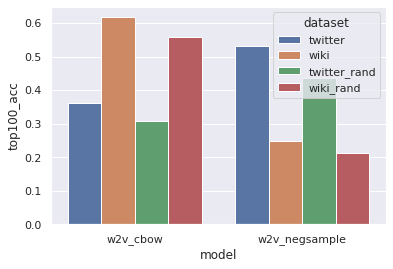

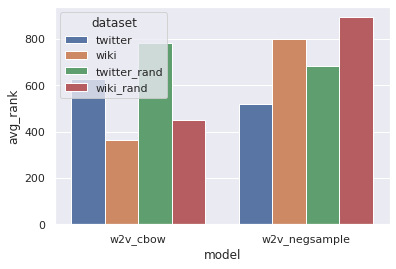

In [66]:
import seaborn as sns
sns.set_theme()

import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'model': ['w2v_cbow', 'w2v_negsample', 'w2v_cbow', 'w2v_negsample',
              'w2v_cbow', 'w2v_negsample', 'w2v_cbow', 'w2v_negsample'],
    'dataset': ['twitter', 'wiki', 'wiki', 'twitter', 'twitter_rand', 'wiki_rand', 'wiki_rand', 'twitter_rand',],
    'avg_rank': [twitter_w2v_cbow_avgrank, wiki_w2v_negsample_avgrank, wiki_w2v_cbow_avgrank,
                 twitter_w2v_negsample_avgrank, twitterrand_w2v_cbow_avgrank, wikirand_w2v_negsample_avgrank, wikirand_w2v_cbow_avgrank,
                 twitterrand_w2v_negsample_avgrank],
    'top100_acc': [twitter_w2v_cbow_top100acc, wiki_w2v_negsample_top100acc, wiki_w2v_cbow_top100acc,
                   twitter_w2v_negsample_top100acc, twitterrand_w2v_cbow_top100acc, wikirand_w2v_negsample_top100acc, wikirand_w2v_cbow_top100acc,
                   twitterrand_w2v_negsample_top100acc],
    
})

sns.barplot(data=df, x='model', y='top100_acc', hue='dataset')
plt.show()

sns.barplot(data=df, x='model', y='avg_rank', hue='dataset')
plt.show()


## Contextual LMs

### load datasets

#### restricted vocab datasets

In [17]:
clm_test_ds_twitter, clm_test_ds_twitter_rand, twitter_pi_dict = create_test_dataset(
    dataset='twitter',
    restrict_vocab_to_training=w2v_twitter_negsamp_model.wv.key_to_index,
    w2v=False
)

clm_test_ds_wiki, clm_test_ds_wiki_rand, wiki_pi_dict = create_test_dataset(
    dataset='wiki',
    restrict_vocab_to_training=w2v_wiki_negsamp_model.wv.key_to_index,
    w2v=False
)

creating dataset for twitter:
total test bios: 1546001
total test bios after restriction: 692671
total PIs: 4750
creating dataset for wiki:
total test bios: 66484
total test bios after restriction: 61475
total PIs: 3922


#### full test dataset

In [3]:
clm_test_ds_full_twitter, _, twitter_pi_dict_full = create_test_dataset(
    dataset='twitter',
    restrict_vocab_to_training=None,
    w2v=False,
    filter_th=10
)

clm_test_ds_full_wiki, _, wiki_pi_dict_full = create_test_dataset(
    dataset='wiki',
    restrict_vocab_to_training=None,
    w2v=False,
    filter_th=None
)

creating dataset for twitter:
total test bios: 1546001
total test bios after restriction: 1546001
total test bios after freq filter: 1001456
total PIs: 49688
creating dataset for wiki:
total test bios: 66484
total test bios after restriction: 66484
total PIs: 15290


#### target restricted dataset

In [8]:
fixed_target_twitter_clm_ds = [(x[1], x[2]) for x in test_ds_twitter_target_restricted]
fixed_target_wiki_clm_ds = [(x[1], x[2]) for x in test_ds_wiki_target_restricted]

### load different models

#### load BERT

In [9]:
from transformers import BertTokenizer, BertModel, BertConfig
import torch

device = 'cuda:0'

config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased", config=config)
bert_model = bert_model.to(device)
bert_model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

#### load RoBERTa

In [10]:
%%time

from sentence_transformers import SentenceTransformer, models, util
from transformers import AutoTokenizer, AutoModel


device = 'cuda:0'
roberta_model = AutoModel.from_pretrained("roberta-base")
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base", use_fast=False)

roberta_model = roberta_model.to(device)
roberta_model.eval()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: user 16.7 s, sys: 415 ms, total: 17.1 s
Wall time: 3.14 s


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

### load bert fine tuned

In [11]:
%%time

from sentence_transformers import SentenceTransformer, models, util
from transformers import AutoTokenizer, AutoModel


device = 'cuda:0'
bert_ft_twitter_model = AutoModel.from_pretrained("./models/bert-ft-mlm-twitter/checkpoint-40612/")
bert_ft_wiki_model = AutoModel.from_pretrained("./models/bert-ft-mlm-wiki/checkpoint-29328/")
bert_ft_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=False)

bert_ft_wiki_model = bert_ft_wiki_model.to(device)
bert_ft_wiki_model.eval()

bert_ft_twitter_model = bert_ft_twitter_model.to(device)
bert_ft_twitter_model.eval()

Some weights of the model checkpoint at ./models/bert-ft-mlm-twitter/checkpoint-40612/ were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ./models/bert-ft-mlm-twitter/checkpoint-40612/ and are newly initialized: ['be

CPU times: user 30.8 s, sys: 560 ms, total: 31.3 s
Wall time: 3.66 s


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

#### load sentenceBERT

In [12]:
%%time

from sentence_transformers import SentenceTransformer, models, util
from transformers import AutoTokenizer, AutoModel

device = 'cuda:0'

sbert_model = SentenceTransformer('all-distilroberta-v1', device=device)
# sbert_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
sbert_model.eval()


/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


CPU times: user 8.88 s, sys: 175 ms, total: 9.05 s
Wall time: 2.4 s


SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

#### load sentenceBERT fine-tuned

In [13]:
%%time

from sentence_transformers import SentenceTransformer, models, util
from transformers import AutoTokenizer, AutoModel


device = 'cuda:0'
twitter_ft_sbert = SentenceTransformer('./models/distilroberta-twitter-freq100/', device=device)
twitter_ft_sbert.eval()

wiki_ft_sbert = SentenceTransformer('./models/distilroberta-wiki-freq3/', device=device)
wiki_ft_sbert.eval()

# wiki_ft_sbert = SentenceTransformer('./models/miniLM-L6-wiki-out256/', device=device)
# wiki_ft_sbert.eval()

# twitter_ft_sbert = SentenceTransformer('./models/miniLM-L6-twitter-out256/', device=device)
# twitter_ft_sbert.eval()

# wiki_ft_sbert = SentenceTransformer('./models/miniLM-L6-wiki-out256/', device=device)
# wiki_ft_sbert.eval()


CPU times: user 17.4 s, sys: 411 ms, total: 17.8 s
Wall time: 2.41 s


SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

## projection model 

### define dimensions

In [57]:
# measures = [{
#     "group": "age",
#     "names": ['young', 'old'],
#     "sets": [['young'], ['old']],
#     "paper": "this_short",
#     "is_paired": True
# }, {
#     "group":
#     "age",
#     "names": ['young', 'old'],
#     "sets": [['young', 'new', 'youthful', 'young'],
#              ['old', 'old', 'elderly', 'aged']],
#     "paper":
#     "this_long",
#     "is_paired":
#     True
# }, {
#     "group": "gender",
#     "names": ['woman', 'man'],
#     "sets": [['female'], ['male']],
#     "paper": "this_short",
#     "is_paired": True
# }, {
#     "group": "gender",
#     "names": ['woman', 'man'],
#     "sets": [['she'], ['he']],
#     "paper": "gonen",
#     "is_paired": True
# }, {
#     "group":
#     "gender",
#     "names": ['woman', 'man'],
#     "sets": [[
#         'woman', 'girl', 'she', 'mother', 'daughter', 'gal', 'female', 'her',
#         'herself', 'Mary'
#     ],
#              [
#                  'man', 'boy', 'he', 'father', 'son', 'guy', 'male', 'his',
#                  'himself', 'John'
#              ]],
#     "paper":
#     "bolukbasi_words",
#     "is_paired":
#     True
# }, {
#     "group":
#     "gender",
#     "names": ['woman', 'man'],
#     "sets":
#     [['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna'],
#      ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']],
#     "paper":
#     "bolukbasi_names",
#     "is_paired":
#     True
# }, {
#     "group":
#     "gender",
#     "names": ['woman', 'man'],
#     "sets": [[
#         'woman', 'women', 'she', 'her', 'her', 'hers', 'girl', 'girls',
#         'female', 'feminine'
#     ],
#              [
#                  'man', 'men', 'he', 'him', 'his', 'his', 'boy', 'boys',
#                  'male', 'masculine'
#              ]],
#     "paper":
#     "kozlowski",
#     "is_paired":
#     True
# }]


# race_ethnicities = ['white', 'latino', 'asian', 'middle eastern', 'black']

# measures += [{
#     "sets": [['white', 'White'], ['hispanic', 'Hispanic', 'latino', 'Latino'],
#              ['asian', 'Asian'], ['arab', 'Arab'], ['black', 'Black']],
#     "names":
#     race_ethnicities,
#     "group":
#     "race_ethnicity",
#     "paper":
#     "this_short",
#     "is_paired":
#     False
# }, {
#     "sets":
#     [['white', 'whites', 'White', 'Whites', 'European', 'Caucasian', 'Anglo'],
#      [
#          'hispanic', 'hispanics', 'Hispanic', 'Hispanics', 'Mexican', 'Latino',
#          'Hispanic'
#      ],
#      ['asian', 'asians', 'Asian', 'Asians', 'Chinese', 'Japanese', 'Korean'],
#      ['arab', 'arabs', 'Arab', 'Arabs', 'Muslim', 'Muslim', 'Muslim'],
#      ['black', 'blacks', 'Black', 'Blacks', 'African', 'African', 'Afro']],
#     "names":
#     race_ethnicities,
#     "group":
#     "race_ethnicity",
#     "paper":
#     "koslowski",
#     "is_paired":
#     False
# }, {
#     "sets": [['white', 'whites', 'european', 'caucasian', 'anglo'],
#              ['hispanic', 'hispanics', 'mexican', 'latino', 'hispanic'],
#              ['asian', 'asians', 'chinese', 'japanese', 'korean'],
#              ['arab', 'arabs', 'muslims', 'muslim', 'arab'],
#              ['black', 'blacks', 'african', 'african', 'afro']],
#     "names":
#     race_ethnicities,
#     "group":
#     "race_ethnicity",
#     "paper":
#     "koslowski_lowercase",
#     "is_paired":
#     False
# }, {
#     "sets":
#     [['white', 'whites', 'White', 'Whites', 'European', 'Caucasian', 'Anglo'],
#      [
#          'hispanic', 'hispanics', 'Hispanic', 'Hispanics', 'Mexican', 'latino',
#          'latinos', 'latina', 'latinas', 'Latino', 'Latinos', 'Latina',
#          'Latinas'
#      ],
#      ['asian', 'asians', 'Asian', 'Asians', 'Chinese', 'Japanese', 'Korean'],
#      [
#          'arab', 'arabs', 'Arab', 'Arabs', 'Muslim', 'Muslims', 'Muslim',
#          'Muslims'
#      ], [
#          'black',
#          'blacks',
#          'Black',
#          'Blacks',
#          'African',
#          'African',
#      ]],
#     "names":
#     race_ethnicities,
#     "group":
#     "race_ethnicity",
#     "paper":
#     "this_long",
#     "is_paired":
#     False
# }]


# measures.append({
#     "group":
#     "politics",
#     "names": ['republican', 'democrat'],
#     "sets": [['republican', 'conservative'], ['democrat', 'democratic']],
#     "paper":
#     "unk",
#     "is_paired":
#     True
# })

In [142]:
measures = [{
    "group": "age",
    "names": ['young', 'old'],
    "sets": [['young'], ['old']],
    "paper": "this_short",
    "is_paired": True
}, {
    "group":
    "age",
    "names": ['young', 'old'],
    "sets": [['young', 'new', 'youthful', 'young'],
             ['old', 'old', 'elderly', 'aged']],
    "paper":
    "this_long",
    "is_paired":
    True
}, {
    "group": "gender",
    "names": ['woman', 'man'],
    "sets": [['female'], ['male']],
    "paper": "this_short",
    "is_paired": True
}, {
    "group": "gender",
    "names": ['woman', 'man'],
    "sets": [['she'], ['he']],
    "paper": "gonen",
    "is_paired": True
}, {
    "group":
    "gender",
    "names": ['woman', 'man'],
    "sets": [[
        'woman', 'girl', 'she', 'mother', 'daughter', 'gal', 'female', 'her',
        'herself', 'Mary'
    ],
             [
                 'man', 'boy', 'he', 'father', 'son', 'guy', 'male', 'his',
                 'himself', 'John'
             ]],
    "paper":
    "bolukbasi_words",
    "is_paired":
    True
}, {
    "group":
    "gender",
    "names": ['woman', 'man'],
    "sets":
    [['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna'],
     ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']],
    "paper":
    "bolukbasi_names",
    "is_paired":
    True
}, {
    "group":
    "gender",
    "names": ['woman', 'man'],
    "sets": [[
        'woman', 'women', 'she', 'her', 'her', 'hers', 'girl', 'girls',
        'female', 'feminine'
    ],
             [
                 'man', 'men', 'he', 'him', 'his', 'his', 'boy', 'boys',
                 'male', 'masculine'
             ]],
    "paper":
    "kozlowski",
    "is_paired":
    True
}]


race_ethnicities = ['white', 'latino', 'asian', 'middle eastern', 'black']

measures += [{
    "sets": [['white', 'White'], ['hispanic', 'Hispanic', 'latino', 'Latino'],
             ['asian', 'Asian'], ['arab', 'Arab'], ['black', 'Black']],
    "names":
    race_ethnicities,
    "group":
    "race_ethnicity",
    "paper":
    "this_short",
    "is_paired":
    False
}, {
    "sets":
    [['white', 'whites', 'White', 'Whites', 'European', 'Caucasian', 'Anglo'],
     [
         'hispanic', 'hispanics', 'Hispanic', 'Hispanics', 'Mexican', 'Latino',
         'Hispanic'
     ],
     ['asian', 'asians', 'Asian', 'Asians', 'Chinese', 'Japanese', 'Korean'],
     ['arab', 'arabs', 'Arab', 'Arabs', 'Muslim', 'Muslim', 'Muslim'],
     ['black', 'blacks', 'Black', 'Blacks', 'African', 'African', 'Afro']],
    "names":
    race_ethnicities,
    "group":
    "race_ethnicity",
    "paper":
    "koslowski",
    "is_paired":
    False
}, {
    "sets": [['white', 'whites', 'european', 'caucasian', 'anglo'],
             ['hispanic', 'hispanics', 'mexican', 'latino', 'hispanic'],
             ['asian', 'asians', 'chinese', 'japanese', 'korean'],
             ['arab', 'arabs', 'muslims', 'muslim', 'arab'],
             ['black', 'blacks', 'african', 'african', 'afro']],
    "names":
    race_ethnicities,
    "group":
    "race_ethnicity",
    "paper":
    "koslowski_lowercase",
    "is_paired":
    False
}, {
    "sets":
    [['white', 'whites', 'White', 'Whites', 'European', 'Caucasian', 'Anglo'],
     [
         'hispanic', 'hispanics', 'Hispanic', 'Hispanics', 'Mexican', 'latino',
         'latinos', 'latina', 'latinas', 'Latino', 'Latinos', 'Latina',
         'Latinas'
     ],
     ['asian', 'asians', 'Asian', 'Asians', 'Chinese', 'Japanese', 'Korean'],
     [
         'arab', 'arabs', 'Arab', 'Arabs', 'Muslim', 'Muslims', 'Muslim',
         'Muslims'
     ], [
         'black',
         'blacks',
         'Black',
         'Blacks',
         'African',
         'African',
     ]],
    "names":
    race_ethnicities,
    "group":
    "race_ethnicity",
    "paper":
    "this_long",
    "is_paired":
    False
}]


measures.append({
    "group":
    "politics",
    "names": ['republican', 'democrat'],
    "sets": [['republican', 'conservative'], ['democrat', 'democratic']],
    "paper":
    "unk",
    "is_paired":
    True
})

### get poles

In [143]:
dims = {}
for m in measures:
    if m['group'] in dims:
        dims[m['group']][0].extend(m['sets'][0])
        dims[m['group']][1].extend(m['sets'][1])
    else:
        dims[m['group']] = [m['sets'][0], m['sets'][1]]
        
for g, p in dims.items():
    p[0] = list(set(p[0]))
    p[1] = list(set(p[1]))
    
len(dims), dims

(4,
 {'age': [['new', 'young', 'youthful'], ['elderly', 'aged', 'old']],
  'gender': [['gal',
    'hers',
    'donna',
    'female',
    'amy',
    'lisa',
    'ann',
    'joan',
    'woman',
    'her',
    'diana',
    'she',
    'women',
    'sarah',
    'girls',
    'Mary',
    'mother',
    'daughter',
    'girl',
    'feminine',
    'kate',
    'herself'],
   ['paul',
    'men',
    'John',
    'mike',
    'his',
    'himself',
    'son',
    'guy',
    'jeff',
    'he',
    'boy',
    'male',
    'man',
    'steve',
    'john',
    'boys',
    'bill',
    'kevin',
    'him',
    'masculine',
    'father',
    'greg']],
  'race_ethnicity': [['Whites',
    'anglo',
    'White',
    'whites',
    'European',
    'european',
    'caucasian',
    'Caucasian',
    'white',
    'Anglo'],
   ['latina',
    'hispanic',
    'latino',
    'Hispanics',
    'latinas',
    'Latinas',
    'hispanics',
    'Latina',
    'Mexican',
    'Hispanic',
    'Latinos',
    'mexican',
    'Latino',
    '

In [144]:
dims.pop('race_ethnicity')

dims['race_ethnicity_wh'] = [
    ['white', 'whites', 'White', 'Whites', 'European', 'Caucasian', 'Anglo'],
    [
        'hispanic', 'hispanics', 'Hispanic', 'Hispanics', 'Mexican', 'latino',
        'latinos', 'latina', 'latinas', 'Latino', 'Latinos', 'Latina',
        'Latinas'
    ]
]

dims['race_ethnicity_was'] = [
    ['white', 'whites', 'White', 'Whites', 'European', 'Caucasian', 'Anglo'],
    ['asian', 'asians', 'Asian', 'Asians', 'Chinese', 'Japanese', 'Korean'],
]

dims['race_ethnicity_wme'] = [[
    'white', 'whites', 'White', 'Whites', 'European', 'Caucasian', 'Anglo'
], [
    'arab', 'arabs', 'Arab', 'Arabs', 'Muslim', 'Muslims', 'Muslim', 'Muslims', 'middle eastern', 'mideast', 'iranian'
]]

dims['race_ethnicity_wb'] = [[
    'white', 'whites', 'White', 'Whites', 'European', 'Caucasian', 'Anglo'
], [
    'black','blacks','Black','Blacks','African','African',
]]

dims

{'age': [['new', 'young', 'youthful'], ['elderly', 'aged', 'old']],
 'gender': [['gal',
   'hers',
   'donna',
   'female',
   'amy',
   'lisa',
   'ann',
   'joan',
   'woman',
   'her',
   'diana',
   'she',
   'women',
   'sarah',
   'girls',
   'Mary',
   'mother',
   'daughter',
   'girl',
   'feminine',
   'kate',
   'herself'],
  ['paul',
   'men',
   'John',
   'mike',
   'his',
   'himself',
   'son',
   'guy',
   'jeff',
   'he',
   'boy',
   'male',
   'man',
   'steve',
   'john',
   'boys',
   'bill',
   'kevin',
   'him',
   'masculine',
   'father',
   'greg']],
 'politics': [['conservative', 'republican'], ['democratic', 'democrat']],
 'race_ethnicity_wh': [['white',
   'whites',
   'White',
   'Whites',
   'European',
   'Caucasian',
   'Anglo'],
  ['hispanic',
   'hispanics',
   'Hispanic',
   'Hispanics',
   'Mexican',
   'latino',
   'latinos',
   'latina',
   'latinas',
   'Latino',
   'Latinos',
   'Latina',
   'Latinas']],
 'race_ethnicity_was': [['white',
   'wh

### generate embeddings

In [145]:
from numpy import linalg as LA
import numpy as np


def normalize(wv):
    # normalize vectors
    norms = np.apply_along_axis(LA.norm, 1, wv)
    wv = wv / (norms[:, np.newaxis]+1e-6)
    return wv


def ripa(w, b):
    return w.dot(b)/LA.norm(b)


def normalize_dict(wv_dict):
    norm_voc = {}
    embs = []
    words = []
    for w, e in wv_dict.items():
        embs.append(e)
        words.append(w)
    embs = normalize(np.array(embs))
    
    for w, e in zip(words, embs):
        norm_voc[w] = e
    
    return norm_voc

def get_contextual_emb(model, word_list, w2v, tokenizer):
    if w2v:
        return model.wv.get_mean_vector(word_list)
    
    ctxt = ','.join(word_list)
    if tokenizer is None:        
        res = get_sbertbased_results_batched(model, [ctxt,], bs=512).numpy()
    else:
        res = get_results_batched(model, tokenizer, [ctxt,], average_k_layers=3, bs=512).numpy()
        
    return res[0]
        

def get_proj_embeddings(model, vocab_set, w2v=True, tokenizer=None):
    pole_voc = {}
    
    print("getting pole embeddings")
    for group, poles in dims.items():
        pole_voc[group] = get_contextual_emb(model, poles[0], w2v, tokenizer) -\
                                get_contextual_emb(model, poles[1], w2v, tokenizer)
    
    print("getting contextual embeddings")
    pi_embs = {}
    if w2v:
        bios = []
        # each vocab is the whole bio
        for ctxt in vocab_set:
            ctxt = ctxt.split(",")
            ctxt = [c.strip() for c in ctxt]
            bios.append(ctxt)
        embs = []
        for pis in tqdm(bios):
            embs.append(model.wv.get_mean_vector(pis))
    else:
        if tokenizer is None:        
            embs = get_sbertbased_results_batched(model, vocab_set, bs=512).numpy()
        else:
            embs = get_results_batched(model, tokenizer, vocab_set, average_k_layers=3, bs=512).numpy()

    for pi, e in zip(vocab_set, embs):
        pi_embs[pi] = e 
            
    print("normalizing embeddings")
    pole_voc = normalize_dict(pole_voc)
    pi_embs = normalize_dict(pi_embs)
    
    pi_prj_embs = {}
    print("calculating projections")
    for pi, e in tqdm(pi_embs.items()):
        prj = []
        for group, diff in pole_voc.items():
            prj.append(ripa(e, diff))
        pi_prj_embs[pi] = np.array(prj)
        
    return pi_prj_embs
    

In [146]:
pis_ctxt, ys = zip(*fixed_target_twitter_clm_ds)
pis_ctxt = list(pis_ctxt)
pis_ctxt.extend(ys)
all_pis_twitter = list(set(pis_ctxt))

pis_ctxt, ys = zip(*fixed_target_wiki_clm_ds)
pis_ctxt = list(pis_ctxt)
pis_ctxt.extend(ys)
all_pis_wiki = list(set(pis_ctxt))

print(f"all pis twitter: {len(all_pis_twitter)}")
print(f"all pis wiki: {len(all_pis_wiki)}")

all pis twitter: 107826
all pis wiki: 73528


In [147]:
twitter_prj_embs_w2v_negsampling = get_proj_embeddings(
    model=w2v_twitter_negsamp_model,
    vocab_set=all_pis_twitter,
    w2v=True,
    tokenizer=None
)

wiki_prj_embs_w2v_cbow = get_proj_embeddings(
    model=w2v_wiki_cbow_model,
    vocab_set=all_pis_wiki,
    w2v=True,
    tokenizer=None
)

getting pole embeddings
getting contextual embeddings



100%|██████████| 107826/107826 [00:03<00:00, 30763.78it/s]


normalizing embeddings
calculating projections



100%|██████████| 107826/107826 [00:04<00:00, 24179.26it/s]


getting pole embeddings
getting contextual embeddings



100%|██████████| 73528/73528 [00:02<00:00, 33962.39it/s]


normalizing embeddings
calculating projections



  0%|          | 0/73528 [00:00<?, ?it/s]/scratch/12775300/ipykernel_14336/2984262842.py:13: RuntimeWarning: invalid value encountered in float_scalars
  return w.dot(b)/LA.norm(b)

100%|██████████| 73528/73528 [00:03<00:00, 24433.29it/s]


In [148]:
import pickle

def save_prj_model(model_name, model):
    with open(model_name, 'wb') as f:
        pickle.dump(model, f)
        
save_prj_model('twitter_prj_embs_w2v_negsampling', twitter_prj_embs_w2v_negsampling)
save_prj_model('wiki_prj_embs_w2v_cbow', wiki_prj_embs_w2v_cbow)


In [149]:
twitter_prj_embs_bert = get_proj_embeddings(
    model=bert_model,
    vocab_set=all_pis_twitter,
    w2v=False,
    tokenizer=bert_tokenizer
)

wiki_prj_embs_bert = get_proj_embeddings(
    model=bert_model,
    vocab_set=all_pis_wiki,
    w2v=False,
    tokenizer=bert_tokenizer
)

twitter_prj_embs_sbert = get_proj_embeddings(
    model=sbert_model,
    vocab_set=all_pis_twitter,
    w2v=False,
    tokenizer=None
)

wiki_prj_embs_sbert = get_proj_embeddings(
    model=sbert_model,
    vocab_set=all_pis_wiki,
    w2v=False,
    tokenizer=None
)

twitter_prj_embs_roberta = get_proj_embeddings(
    model=roberta_model,
    vocab_set=all_pis_twitter,
    w2v=False,
    tokenizer=roberta_tokenizer
)

wiki_prj_embs_roberta = get_proj_embeddings(
    model=roberta_model,
    vocab_set=all_pis_wiki,
    w2v=False,
    tokenizer=roberta_tokenizer
)

twitter_prj_embs_ftsbert = get_proj_embeddings(
    model=twitter_ft_sbert,
    vocab_set=all_pis_twitter,
    w2v=False,
    tokenizer=None
)

wiki_prj_embs_ftsbert = get_proj_embeddings(
    model=wiki_ft_sbert,
    vocab_set=all_pis_wiki,
    w2v=False,
    tokenizer=None
)

twitter_prj_embs_ftbert = get_proj_embeddings(
    model=bert_ft_twitter_model,
    vocab_set=all_pis_twitter,
    w2v=False,
    tokenizer=bert_tokenizer
)

wiki_prj_embs_ftbert = get_proj_embeddings(
    model=bert_ft_wiki_model,
    vocab_set=all_pis_wiki,
    w2v=False,
    tokenizer=bert_tokenizer
)

getting pole embeddings



512it [00:00, 49277.95it/s]          

512it [00:00, 56709.72it/s]          

512it [00:00, 53286.11it/s]          

512it [00:00, 54640.57it/s]          

512it [00:00, 59113.73it/s]          

512it [00:00, 58648.78it/s]          

512it [00:00, 57821.32it/s]          

512it [00:00, 55048.16it/s]          

512it [00:00, 59144.67it/s]          

512it [00:00, 54812.11it/s]          

512it [00:00, 58043.24it/s]          

512it [00:00, 55563.76it/s]          

512it [00:00, 58246.32it/s]          

512it [00:00, 57994.64it/s]          


getting contextual embeddings



 65%|██████▍   | 69632/107826 [00:50<00:27, 1393.37it/s]


100%|█████████▉| 107520/107826 [01:15<00:00, 1443.57it/s]
108032it [01:16, 1419.94it/s]                            


normalizing embeddings
calculating projections



100%|██████████| 107826/107826 [00:04<00:00, 23904.20it/s]


getting pole embeddings



512it [00:00, 50559.96it/s]          

512it [00:00, 58338.10it/s]          

512it [00:00, 54555.89it/s]          

512it [00:00, 45213.99it/s]          

512it [00:00, 59605.96it/s]          

512it [00:00, 59426.17it/s]          

512it [00:00, 59037.35it/s]          

512it [00:00, 55496.27it/s]          

512it [00:00, 59350.62it/s]          

512it [00:00, 55403.21it/s]          

512it [00:00, 59495.32it/s]          

512it [00:00, 55972.15it/s]          

512it [00:00, 58738.61it/s]          

512it [00:00, 59518.41it/s]          


getting contextual embeddings



 96%|█████████▌| 70656/73528 [00:36<00:01, 2309.82it/s]


100%|█████████▉| 73216/73528 [00:37<00:00, 1945.27it/s]
73728it [00:37, 1961.13it/s]                           


normalizing embeddings
calculating projections



100%|██████████| 73528/73528 [00:03<00:00, 24353.04it/s]


getting pole embeddings



512it [00:00, 55794.74it/s]          

512it [00:00, 79421.71it/s]          

512it [00:00, 74708.08it/s]          

512it [00:00, 79471.68it/s]          

512it [00:00, 83765.01it/s]          

512it [00:00, 84037.08it/s]          

512it [00:00, 75658.25it/s]          

512it [00:00, 77306.01it/s]          

512it [00:00, 80016.53it/s]          

512it [00:00, 80091.14it/s]          

512it [00:00, 76458.28it/s]          

512it [00:00, 78760.49it/s]          

512it [00:00, 76643.84it/s]          

512it [00:00, 80297.77it/s]          


getting contextual embeddings



 96%|█████████▌| 103424/107826 [00:20<00:00, 5083.34it/s]


 99%|█████████▉| 107008/107826 [00:20<00:00, 5139.43it/s]
108032it [00:21, 5100.20it/s]                            


normalizing embeddings
calculating projections



100%|██████████| 107826/107826 [00:04<00:00, 23407.05it/s]


getting pole embeddings



512it [00:00, 61553.65it/s]          

512it [00:00, 79826.17it/s]          

512it [00:00, 78697.00it/s]          

512it [00:00, 79330.76it/s]          

512it [00:00, 81927.50it/s]          

512it [00:00, 84125.97it/s]          

512it [00:00, 78798.06it/s]          

512it [00:00, 77694.78it/s]          

512it [00:00, 78934.19it/s]          

512it [00:00, 77045.30it/s]          

512it [00:00, 80336.82it/s]          

512it [00:00, 77680.73it/s]          

512it [00:00, 77280.97it/s]          

512it [00:00, 84056.82it/s]          


getting contextual embeddings



 99%|█████████▉| 72704/73528 [00:13<00:00, 5356.84it/s]
73728it [00:13, 5350.67it/s]                           


normalizing embeddings
calculating projections



100%|██████████| 73528/73528 [00:03<00:00, 23510.06it/s]


getting pole embeddings



512it [00:00, 46489.37it/s]          

512it [00:00, 56822.26it/s]          

512it [00:00, 53163.43it/s]          

512it [00:00, 54699.02it/s]          

512it [00:00, 59222.96it/s]          

512it [00:00, 58101.34it/s]          

512it [00:00, 54575.30it/s]          

512it [00:00, 55526.40it/s]          

512it [00:00, 54974.88it/s]          

512it [00:00, 55055.21it/s]          

512it [00:00, 55926.97it/s]          

512it [00:00, 54080.53it/s]          

512it [00:00, 54528.19it/s]          

512it [00:00, 59105.60it/s]          


getting contextual embeddings



 65%|██████▍   | 69632/107826 [00:40<00:20, 1897.90it/s]


100%|█████████▉| 107520/107826 [01:00<00:00, 1828.87it/s]
108032it [01:01, 1768.96it/s]                            


normalizing embeddings
calculating projections



100%|██████████| 107826/107826 [00:04<00:00, 24304.46it/s]


getting pole embeddings



512it [00:00, 53620.07it/s]          

512it [00:00, 57516.23it/s]          

512it [00:00, 55176.87it/s]          

512it [00:00, 56034.96it/s]          

512it [00:00, 59730.30it/s]          

512it [00:00, 59751.91it/s]          

512it [00:00, 54163.73it/s]          

512it [00:00, 56570.79it/s]          

512it [00:00, 55246.42it/s]          

512it [00:00, 47527.52it/s]          

512it [00:00, 56266.93it/s]          

512it [00:00, 56150.70it/s]          

512it [00:00, 56923.17it/s]          

512it [00:00, 59404.80it/s]          


getting contextual embeddings



 96%|█████████▌| 70656/73528 [00:31<00:01, 2735.57it/s]


100%|█████████▉| 73216/73528 [00:32<00:00, 2122.23it/s]
73728it [00:32, 2251.14it/s]                           


normalizing embeddings
calculating projections



100%|██████████| 73528/73528 [00:03<00:00, 24450.52it/s]


getting pole embeddings



512it [00:00, 65920.24it/s]          

512it [00:00, 80213.79it/s]          

512it [00:00, 78212.61it/s]          

512it [00:00, 79038.78it/s]          

512it [00:00, 81144.29it/s]          

512it [00:00, 85431.18it/s]          

512it [00:00, 76490.96it/s]          

512it [00:00, 80490.39it/s]          

512it [00:00, 80902.79it/s]          

512it [00:00, 80963.79it/s]          

512it [00:00, 78458.36it/s]          

512it [00:00, 77025.96it/s]          

512it [00:00, 79251.71it/s]          

512it [00:00, 79716.53it/s]          


getting contextual embeddings



 99%|█████████▉| 106496/107826 [00:20<00:00, 5180.53it/s]
108032it [00:20, 5220.34it/s]                            


normalizing embeddings
calculating projections



100%|██████████| 107826/107826 [00:04<00:00, 24657.21it/s]


getting pole embeddings



512it [00:00, 67816.70it/s]          

512it [00:00, 82576.47it/s]          

512it [00:00, 75909.64it/s]          

512it [00:00, 77675.11it/s]          

512it [00:00, 80448.18it/s]          

512it [00:00, 83971.36it/s]          

512it [00:00, 77045.30it/s]          

512it [00:00, 79193.26it/s]          

512it [00:00, 77236.50it/s]          

512it [00:00, 78025.06it/s]          

512it [00:00, 77342.20it/s]          

512it [00:00, 77593.71it/s]          

512it [00:00, 76857.79it/s]          

512it [00:00, 81965.02it/s]          


getting contextual embeddings



100%|█████████▉| 107520/107826 [01:11<00:00, 1449.34it/s]
108032it [01:11, 1503.61it/s]                            


normalizing embeddings
calculating projections



100%|██████████| 107826/107826 [00:04<00:00, 24474.53it/s]


getting pole embeddings



512it [00:00, 50179.54it/s]          

512it [00:00, 59544.81it/s]          

512it [00:00, 55210.91it/s]          

512it [00:00, 55588.21it/s]          

512it [00:00, 58995.18it/s]          

512it [00:00, 60302.25it/s]          

512it [00:00, 60056.03it/s]          

512it [00:00, 56258.09it/s]          

512it [00:00, 59668.90it/s]          

512it [00:00, 56888.49it/s]          

512it [00:00, 59068.20it/s]          

512it [00:00, 55483.37it/s]          

512it [00:00, 58287.43it/s]          

512it [00:00, 59538.21it/s]          


getting contextual embeddings



 96%|█████████▌| 70656/73528 [00:41<00:01, 1845.76it/s]


100%|█████████▉| 73216/73528 [00:43<00:00, 1505.52it/s]
73728it [00:43, 1676.69it/s]                           


normalizing embeddings
calculating projections



100%|██████████| 73528/73528 [00:03<00:00, 24098.14it/s]


In [150]:
save_prj_model('twitter_prj_embs_bert', twitter_prj_embs_bert)
save_prj_model('wiki_prj_embs_bert', wiki_prj_embs_bert)

save_prj_model('twitter_prj_embs_sbert', twitter_prj_embs_sbert)
save_prj_model('wiki_prj_embs_sbert', wiki_prj_embs_sbert)

save_prj_model('twitter_prj_embs_roberta', twitter_prj_embs_roberta)
save_prj_model('wiki_prj_embs_roberta', wiki_prj_embs_roberta)

save_prj_model('twitter_prj_embs_ftbert', twitter_prj_embs_ftbert)
save_prj_model('wiki_prj_embs_ftbert', wiki_prj_embs_ftbert)

save_prj_model('twitter_prj_embs_ftsbert', twitter_prj_embs_ftsbert)
save_prj_model('wiki_prj_embs_ftsbert', wiki_prj_embs_ftsbert)

In [151]:
twitter_prj_embs_bert['athlete']

array([-0.03860485,  0.10575881,  0.03730018,  0.00934982, -0.04488732,
        0.04463677, -0.03385609], dtype=float32)

### calculate correlation with survey

In [153]:
list(dims.keys())

['age',
 'gender',
 'politics',
 'race_ethnicity_wh',
 'race_ethnicity_was',
 'race_ethnicity_wme',
 'race_ethnicity_wb']

In [190]:
import pandas as pd

df = pd.read_csv("data/dimension_data.csv")

dim_names = ['age', 'gender', 'partisanship', 'white', 'hispanic', 'asian', 'mideast', 'black']

emb_models = {
    
#     'wiki_prj_embs_w2v_cbow': wiki_prj_embs_w2v_cbow,
    'twitter_prj_embs_bert': twitter_prj_embs_bert,
#     'wiki_prj_embs_bert': wiki_prj_embs_bert,
    'twitter_prj_embs_sbert': twitter_prj_embs_sbert,
#     'wiki_prj_embs_sbert': wiki_prj_embs_sbert,
    'twitter_prj_embs_roberta': twitter_prj_embs_roberta,
#     'wiki_prj_embs_roberta': wiki_prj_embs_roberta,
    'twitter_prj_embs_ftbert': twitter_prj_embs_ftbert,
    'twitter_prj_embs_w2v_negsampling': twitter_prj_embs_w2v_negsampling,
#     'wiki_prj_embs_ftbert': wiki_prj_embs_ftbert,
    'twitter_prj_embs_ftsbert': twitter_prj_embs_ftsbert,
#     'wiki_prj_embs_ftsbert': wiki_prj_embs_ftsbert,
}

dim_idx = {
    'age': 0,
    'gender': 1,
    'partisanship': 2,
    'white': 6,
    'hispanic': 3,
    'asian': 4,
    'mideast': 5,
    'black': 6
}


model_vals = {m: [] for m in emb_model}
missing = 0
for model_name, e in tqdm(emb_models.items()):
    for _,row in df.iterrows():
        if row.identity not in e:
            missing += 1
            print(f" {model_name} missing {row.identity}")
            continue
        model_vals[model_name].append(e[row.identity][dim_idx[row.dimension]])
        
model_embs_df = pd.DataFrame(model_vals)
model_embs_df


100%|██████████| 6/6 [00:00<00:00, 12.52it/s]


,twitter_prj_embs_w2v_negsampling,twitter_prj_embs_bert,twitter_prj_embs_sbert,twitter_prj_embs_roberta,twitter_prj_embs_ftbert,twitter_prj_embs_ftsbert
0,-0.014609,-0.042594,0.166414,-0.091378,-0.029569,0.086334
1,0.045082,0.011889,-0.091023,-0.091625,-0.010171,0.242217
2,-0.001400,-0.038605,-0.059559,-0.092179,0.104655,0.212110
3,-0.036465,-0.047591,-0.023639,-0.091946,-0.050010,0.029570
4,0.023685,-0.080903,0.031600,-0.091149,-0.068943,-0.130881
...,...,...,...,...,...,...
1347,0.018706,0.075130,-0.024967,0.024263,-0.081970,0.032730
1348,0.018667,0.124366,-0.024781,0.025539,-0.093322,-0.276632
1349,-0.039446,-0.131783,-0.057809,0.025189,-0.002590,0.260298
1350,-0.030297,0.018627,-0.085716,0.024145,-0.122544,-0.221299


In [191]:
df_all = pd.concat([df, model_embs_df], axis=1)
df_all

,dimension,identity,mean_value,twitter_prj_embs_w2v_negsampling,twitter_prj_embs_bert,twitter_prj_embs_sbert,twitter_prj_embs_roberta,twitter_prj_embs_ftbert,twitter_prj_embs_ftsbert
0,age,freelance writer,42.066667,-0.014609,-0.042594,0.166414,-0.091378,-0.029569,0.086334
1,age,die hard fan,39.300000,0.045082,0.011889,-0.091023,-0.091625,-0.010171,0.242217
2,age,athlete,31.300000,-0.001400,-0.038605,-0.059559,-0.092179,0.104655,0.212110
3,age,phd,33.000000,-0.036465,-0.047591,-0.023639,-0.091946,-0.050010,0.029570
4,age,irish,66.300000,0.023685,-0.080903,0.031600,-0.091149,-0.068943,-0.130881
...,...,...,...,...,...,...,...,...,...
1347,black,yoga,15.000000,0.018706,0.075130,-0.024967,0.024263,-0.081970,0.032730
1348,black,freelancer,20.000000,0.018667,0.124366,-0.024781,0.025539,-0.093322,-0.276632
1349,black,biden2020,52.000000,-0.039446,-0.131783,-0.057809,0.025189,-0.002590,0.260298
1350,black,aquarius,38.000000,-0.030297,0.018627,-0.085716,0.024145,-0.122544,-0.221299


In [192]:
final_df = pd.DataFrame({'dimension':[], 'corr':[] ,'model':[]})
for model_name in emb_models:
    corr_df = df_all[['dimension', 'mean_value', model_name]].groupby('dimension').corr().unstack()
    corr_df.columns = ['vv', 'corr', 'cv', 'cc']
    corr_df = corr_df.reset_index().drop(columns=['vv', 'cv', 'cc'])
    corr_df['model'] = model_name
    final_df = pd.concat([final_df, corr_df], axis=0)
    
final_df

,dimension,corr,model
0,age,-0.051989,twitter_prj_embs_bert
1,asian,-0.135475,twitter_prj_embs_bert
2,black,-0.145940,twitter_prj_embs_bert
3,gender,0.116450,twitter_prj_embs_bert
4,hispanic,-0.156621,twitter_prj_embs_bert
5,mideast,-0.028892,twitter_prj_embs_bert
6,partisanship,0.053493,twitter_prj_embs_bert
7,white,-0.006333,twitter_prj_embs_bert
0,age,-0.151604,twitter_prj_embs_sbert
1,asian,-0.163471,twitter_prj_embs_sbert


In [193]:
final_df.to_csv('dimension_corr.csv', header=True, index=False)

In [194]:
!head dimension_corr.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
dimension,corr,model
age,-0.05198876086279595,twitter_prj_embs_bert
asian,-0.13547543828855468,twitter_prj_embs_bert
black,-0.14593986187554375,twitter_prj_embs_bert
gender,0.11644953783468537,twitter_prj_embs_bert
hispanic,-0.15662077167338898,twitter_prj_embs_bert
mideast,-0.02889175873486247,twitter_prj_embs_bert
partisanship,0.053493138535627864,twitter_prj_embs_bert
white,-0.006332724037618329,twitter_prj_embs_bert
age,-0.15160410295254292,twitter_prj_embs_sbert


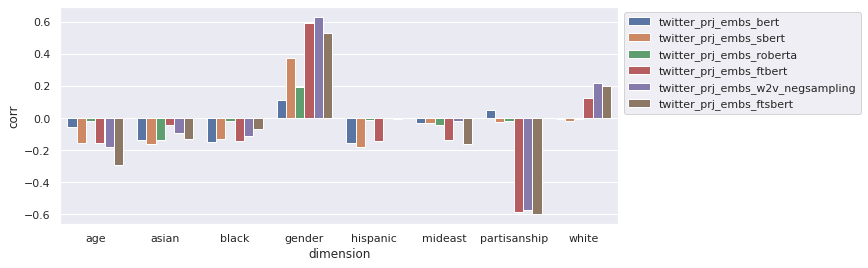

In [195]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

plt.figure(figsize=(10,4))
ax = sns.barplot(data=final_df, x='dimension', y='corr', hue='model')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()


### load models

In [114]:
print(twitter_prj_embs_bert["maga"], twitter_prj_embs_bert["biden"])
print(twitter_prj_embs_ftsbert["maga"], twitter_prj_embs_ftsbert["biden"])
print(twitter_prj_embs_ftsbert["senior citizen"], twitter_prj_embs_ftsbert["bitchy"])
print(twitter_prj_embs_bert["senior citizen"], twitter_prj_embs_bert["bitchy"])
print(twitter_prj_embs_bert["obama"], twitter_prj_embs_bert["trump"])
print(twitter_prj_embs_ftsbert["biden"], twitter_prj_embs_ftsbert["trump"])

[-0.01770229  0.02142975  0.18612933  0.16223718  0.10094698  0.08112644
  0.02124578] [-0.05316342 -0.00054405  0.18283652  0.10238793  0.04137545 -0.01337528
 -0.02406338]
[-0.38811404 -0.37582284  0.35945314  0.29864922  0.31617987  0.34761146
  0.33521158] [-0.26899248 -0.05552626 -0.09606277  0.28867093  0.4234584   0.4913753
  0.2862389 ]
[-0.4879075  -0.19511789  0.29545274  0.14227884  0.12528896  0.14321588
  0.3394835 ] [ 0.13116433  0.42455527 -0.11828844 -0.24977593  0.01294443  0.17824344
 -0.13836242]
[-0.00044577  0.0512145   0.18619873  0.07702278  0.00274081 -0.03361264
  0.01124361] [-8.8289395e-05  1.7027218e-02  2.7099803e-01  2.4983057e-01
  2.1646912e-01  1.6950129e-01  1.6405986e-01]
[ 0.02415831 -0.00961768  0.22274762  0.10528763  0.05150649  0.00680339
 -0.03428238] [-0.00724131 -0.03044956  0.15636824  0.14056493  0.10156041  0.04647675
  0.01527737]
[-0.26899248 -0.05552626 -0.09606277  0.28867093  0.4234584   0.4913753
  0.2862389 ] [-0.40082923 -0.34183952

### calculate metrics

In [115]:
%%time
import torch
from tqdm import tqdm
from torch.nn.functional import log_softmax


def calculate_prj_metrics(prj_model, dataset, cosine_bs=512):
    print("calculating embeddings...")
    X, ys = zip(*dataset)

    pi_list = list(set(ys))
    pi_dict = {}
    for pi in pi_list:
        pi_dict[pi] = len(pi_dict)
        
    
    emb_x = torch.tensor([prj_model[x] for x in X])
    emb_all = torch.tensor([prj_model[y] for y in pi_list])

    print("calculating ranks...")
    
    i = 0
    pbar = tqdm(total=emb_x.shape[0])

    target_ranks = []
    softmax_scores = []
    
    while i < emb_x.shape[0]:
        batch = emb_x[i:i+cosine_bs]
        batch_y = ys[i:i+cosine_bs]
        batch_cosine_scores = util.cos_sim(batch.to(device), emb_all.to(device))
        batch_softmax = log_softmax(batch_cosine_scores, dim=1)
        ranks = torch.argsort(torch.argsort(batch_cosine_scores, dim=1, descending=True), dim=1)
        target_idxs = torch.tensor([pi_dict[y] for y in batch_y], dtype=torch.int64, device=device)
        
        batch_target_ranks = torch.gather(ranks, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)
        batch_target_scores = torch.gather(batch_softmax, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)
        
        target_ranks.append(batch_target_ranks)
        softmax_scores.append(batch_target_scores)
        
        i += cosine_bs
        pbar.update(cosine_bs)


    target_ranks = torch.concat(target_ranks)
    softmax_scores = torch.concat(softmax_scores)
    
    avg_score = torch.mean(softmax_scores).item()
    avg_rank = torch.mean(target_ranks).item()
    top100_acc = len([r for r in target_ranks.reshape(1,-1).squeeze().tolist() if r < 100])/emb_x.shape[0]
    
    print(avg_rank, top100_acc, avg_score)
    
    return avg_rank, top100_acc, avg_score



CPU times: user 37 µs, sys: 0 ns, total: 37 µs
Wall time: 42.9 µs


In [79]:
twitter_w2v_prj_avg_rank, twitter_w2v_prj_top100acc, twitter_w2v_prj_avg_score = calculate_prj_metrics(twitter_prj_embs_w2v_negsampling, fixed_target_twitter_clm_ds)
twitter_bert_prj_avg_rank, twitter_bert_prj_top100acc, twitter_bert_prj_avg_score = calculate_prj_metrics(twitter_prj_embs_bert, fixed_target_twitter_clm_ds)
twitter_roberta_prj_avg_rank, twitter_roberta_prj_top100acc, twitter_roberta_prj_avg_score = calculate_prj_metrics(twitter_prj_embs_roberta, fixed_target_twitter_clm_ds)
twitter_sbert_prj_avg_rank, twitter_sbert_prj_top100acc, twitter_sbert_prj_avg_score = calculate_prj_metrics(twitter_prj_embs_sbert, fixed_target_twitter_clm_ds)
twitter_bertft_prj_avg_rank, twitter_bertft_prj_top100acc, twitter_bertft_prj_avg_score = calculate_prj_metrics(twitter_prj_embs_ftbert, fixed_target_twitter_clm_ds)
twitter_sbertft_prj_avg_rank, twitter_sbertft_prj_top100acc, twitter_sbertft_prj_avg_score = calculate_prj_metrics(twitter_prj_embs_ftsbert, fixed_target_twitter_clm_ds)

calculating embeddings...
calculating ranks...


100352it [00:01, 93129.19it/s]                           


5729.392578125 0.07629 -9.552691459655762
calculating embeddings...
calculating ranks...


100352it [00:01, 96669.18it/s]                            


8218.3125 0.00754 -9.73948860168457
calculating embeddings...
calculating ranks...


100352it [00:01, 98030.18it/s]                            


8253.6572265625 0.00609 -9.729604721069336
calculating embeddings...
calculating ranks...


100352it [00:01, 85376.89it/s]                            


7326.5771484375 0.01952 -9.713995933532715
calculating embeddings...
calculating ranks...


100352it [00:01, 93759.20it/s]                            


5145.84814453125 0.03871 -9.50649642944336
calculating embeddings...
calculating ranks...


100352it [00:01, 95372.89it/s]                            

4727.4052734375 0.0497 -9.455304145812988


In [80]:
wiki_w2v_prj_avg_rank, wiki_w2v_prj_top100acc, wiki_w2v_prj_avg_score = calculate_prj_metrics(wiki_prj_embs_w2v_cbow, fixed_target_wiki_clm_ds)
wiki_bert_prj_avg_rank, wiki_bert_prj_top100acc, wiki_bert_prj_avg_score = calculate_prj_metrics(wiki_prj_embs_bert, fixed_target_wiki_clm_ds)
wiki_roberta_prj_avg_rank, wiki_roberta_prj_top100acc, wiki_roberta_prj_avg_score = calculate_prj_metrics(wiki_prj_embs_roberta, fixed_target_wiki_clm_ds)
wiki_sbert_prj_avg_rank, wiki_sbert_prj_top100acc, wiki_sbert_prj_avg_score = calculate_prj_metrics(wiki_prj_embs_sbert, fixed_target_wiki_clm_ds)
wiki_bertft_prj_avg_rank, wiki_bertft_prj_top100acc, wiki_bertft_prj_avg_score = calculate_prj_metrics(wiki_prj_embs_ftbert, fixed_target_wiki_clm_ds)
wiki_sbertft_prj_avg_rank, wiki_sbertft_prj_top100acc, wiki_sbertft_prj_avg_score = calculate_prj_metrics(wiki_prj_embs_ftsbert, fixed_target_wiki_clm_ds)


calculating embeddings...
calculating ranks...


165888it [00:00, 198594.08it/s]                            


2009.242919921875 0.09565332754420243 -8.540060043334961
calculating embeddings...
calculating ranks...


165888it [00:00, 217336.62it/s]                            


2897.7236328125 0.019785560942663483 -8.807369232177734
calculating embeddings...
calculating ranks...


165888it [00:00, 216727.20it/s]                            


3403.496337890625 0.01792821477675664 -8.835494995117188
calculating embeddings...
calculating ranks...


165888it [00:00, 209865.30it/s]                            


2875.666748046875 0.026666184239091107 -8.798206329345703
calculating embeddings...
calculating ranks...


165888it [00:00, 217860.82it/s]                            


2117.8427734375 0.08306196782208071 -8.642984390258789
calculating embeddings...
calculating ranks...


165888it [00:00, 214249.97it/s]                            

1359.3431396484375 0.2321562100489664 -8.512412071228027


## frequency baseline

In [15]:
from collections import Counter
from tqdm import tqdm

def load_bios(dataset='twitter', mode='test'):
    with open(f'data/{dataset}_{mode}_bios.pkl', 'rb') as f:
        bios = pickle.load(f)
    
    return bios


def calculate_freq_ranks(dataset_name, dataset, return_ranks=False):

    bios = load_bios(dataset=dataset_name, mode='train')
    cntr = Counter()

    _, ys = zip(*dataset)
    y_set = set(ys)
    
    for bio in tqdm(bios):
        for pi in bio:
            if pi in y_set:
                cntr.update([pi])

    
    ranks_d = {item[1][0]: item[0] for item in enumerate(cntr.most_common())}
    ranks = [ranks_d[x] for x in ys]
    avg_rank = np.mean(ranks)
    top100_acc = np.sum(np.where(np.array(ranks)<=100, 1., 0.))/len(ranks)
    
    if return_ranks:
        return avg_rank, top100_acc, ranks

    return avg_rank, top100_acc
    
# twitter_freq_based_avg_rank, twitter_freq_based_top100acc, twitter_freq_based_ranks = calculate_freq_ranks('twitter', fixed_target_twitter_clm_ds, return_ranks=True)
wiki_freq_based_avg_rank, wiki_freq_based_top100acc, wiki_freq_based_ranks = calculate_freq_ranks('wiki', fixed_target_wiki_clm_ds, return_ranks=True)
# wiki_freq_based_avg_rank, wiki_freq_based_top100acc = calculate_freq_ranks('wiki', fixed_target_wiki_clm_ds)


100%|██████████| 788343/788343 [00:01<00:00, 677493.32it/s]


## calculate metrics

In [14]:
%%time
import torch
from sentence_transformers import SentenceTransformer, models, util
from tqdm import tqdm
from torch.nn.functional import log_softmax



def normalize(word_vectors):
    norms = torch.norm(word_vectors, dim=1, keepdim=True)
    res = word_vectors / (norms + 1e-6)
    return res

def calculate_clm_based_metrics(clm_model, tokenizer, dataset, pi_dict,
                                default_encoder=False, device='cuda:0', average_k_layers=3,
                                cosine_bs=512, emb_bs=512, return_ranks=False):
    print("calculating embeddings...")
    pi_list = list(pi_dict.keys())
    X, ys = zip(*dataset)
    
    if default_encoder:        
        emb_x = get_sbertbased_results_batched(clm_model, X, bs=emb_bs)
        emb_all = get_sbertbased_results_batched(clm_model, pi_list, bs=emb_bs)
            
    else:
        emb_x = get_results_batched(clm_model, tokenizer, X, average_k_layers=average_k_layers, bs=emb_bs)
        emb_all = get_results_batched(clm_model, tokenizer, pi_list, average_k_layers=average_k_layers, bs=emb_bs)

    print("calculating ranks...")
    
    emb_x = normalize(emb_x)
    emb_all = normalize(emb_all)
    
    
    i = 0
    pbar = tqdm(total=emb_x.shape[0])

    target_ranks = []
    softmax_scores = []
    
    while i < emb_x.shape[0]:
        batch = emb_x[i:i+cosine_bs]
        batch_y = ys[i:i+cosine_bs]
        batch_cosine_scores = util.cos_sim(batch.to(device), emb_all.to(device))
        batch_softmax = log_softmax(batch_cosine_scores, dim=1)
#         print(torch.sum(batch_softmax, dim=1), torch.sum(batch_softmax, dim=1).shape)
        ranks = torch.argsort(torch.argsort(batch_cosine_scores, dim=1, descending=True), dim=1)
        target_idxs = torch.tensor([pi_dict[y] for y in batch_y], dtype=torch.int64, device=device)
        
        batch_target_ranks = torch.gather(ranks, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)
        batch_target_scores = torch.gather(batch_softmax, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)
        
        target_ranks.append(batch_target_ranks)
        softmax_scores.append(batch_target_scores)
        
        i += cosine_bs
        pbar.update(cosine_bs)


    target_ranks = torch.concat(target_ranks)
    softmax_scores = torch.concat(softmax_scores)
    
#     print(softmax_scores)

    avg_score = torch.mean(softmax_scores).item()
    avg_rank = torch.mean(target_ranks).item()
    top100_acc = len([r for r in target_ranks.reshape(1,-1).squeeze().tolist() if r < len(pi_list)//100])/emb_x.shape[0]
    
    print(avg_rank, top100_acc, avg_score)
    
    if return_ranks:
        return avg_rank, top100_acc, avg_score, target_ranks.tolist()
    return avg_rank, top100_acc, avg_score

CPU times: user 27 µs, sys: 0 ns, total: 27 µs
Wall time: 30.5 µs


### twitter restricted target experiments

In [15]:
%%time

# sbert and its finetuned
twitter_sbertft_avg_rank, twitter_sbertft_top100acc, twitter_sbertft_avg_score, twitter_sbertft_ranks = calculate_clm_based_metrics(
    clm_model=twitter_ft_sbert,
    tokenizer=None,
    dataset=fixed_target_twitter_clm_ds,
    pi_dict=twitter_target_restricted_pis,
    default_encoder=True,
    return_ranks=True,
)

twitter_sbert_avg_rank, twitter_sbert_top100acc, twitter_sbert_avg_score, twitter_sbert_ranks =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=fixed_target_twitter_clm_ds,
    pi_dict=twitter_target_restricted_pis,
    default_encoder=True,
    return_ranks=True,
)

# bert and roberta

twitter_bert_avg_rank, twitter_bert_top100acc, twitter_bert_avg_score, twitter_bert_ranks = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=fixed_target_twitter_clm_ds,
    pi_dict=twitter_target_restricted_pis,
    default_encoder=False,
    return_ranks=True,
    average_k_layers=1
)

twitter_roberta_avg_rank, twitter_roberta_top100acc, twitter_roberta_avg_score, twitter_roberta_ranks =  calculate_clm_based_metrics(
    clm_model=roberta_model,
    tokenizer=roberta_tokenizer,
    dataset=fixed_target_twitter_clm_ds,
    pi_dict=twitter_target_restricted_pis,
    default_encoder=False,
    return_ranks=True,
    average_k_layers=1
)

twitter_bertft_avg_rank, twitter_bertft_top100acc, twitter_bertft_avg_score, twitter_bertft_ranks =  calculate_clm_based_metrics(
    clm_model=bert_ft_twitter_model,
    tokenizer=bert_ft_tokenizer,
    dataset=fixed_target_twitter_clm_ds,
    pi_dict=twitter_target_restricted_pis,
    default_encoder=False,
    return_ranks=True,
    average_k_layers=1
)


calculating embeddings...


100352it [00:21, 4633.31it/s]                           
22528it [00:04, 4754.36it/s]                           


calculating ranks...


100352it [00:03, 29205.86it/s]                           


3089.57080078125 0.10822 -9.698498725891113
calculating embeddings...


100352it [00:22, 4542.24it/s]                           
22528it [00:04, 4881.57it/s]                           


calculating ranks...


100352it [00:02, 34690.57it/s]                           

6020.0888671875 0.1572 -9.935227394104004
calculating embeddings...



100352it [01:07, 1493.44it/s]                           
22528it [00:05, 3845.65it/s]                           


calculating ranks...


100352it [00:02, 36134.00it/s]                           


9594.322265625 0.0518 -10.010916709899902
calculating embeddings...


100352it [01:00, 1665.04it/s]                           
22528it [00:05, 4347.40it/s]                           


calculating ranks...


100352it [00:02, 34628.84it/s]                           


9227.759765625 0.03624 -10.02178955078125
calculating embeddings...


100352it [01:07, 1489.82it/s]                           
22528it [00:05, 3889.89it/s]                           


calculating ranks...


100352it [00:03, 30497.73it/s]                           

4449.90673828125 0.25427 -9.863913536071777
CPU times: user 17min 20s, sys: 1min 21s, total: 18min 41s
Wall time: 4min 41s


## wiki restricted target experiments

In [16]:
%%time

# sbert and its finetuned
wiki_sbertft_avg_rank, wiki_sbertft_top100acc, wiki_sbertft_avg_score, wiki_sbertft_ranks = calculate_clm_based_metrics(
    clm_model=wiki_ft_sbert,
    tokenizer=None,
    dataset=fixed_target_wiki_clm_ds,
    pi_dict=wiki_target_restricted_pis,
    default_encoder=True,
    return_ranks=True,
)

wiki_sbert_avg_rank, wiki_sbert_top100acc, wiki_sbert_avg_score, wiki_sbert_ranks =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=fixed_target_wiki_clm_ds,
    pi_dict=wiki_target_restricted_pis,
    default_encoder=True,
    return_ranks=True,
)

# bert and roberta

wiki_bert_avg_rank, wiki_bert_top100acc, wiki_bert_avg_score, wiki_bert_ranks = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=fixed_target_wiki_clm_ds,
    pi_dict=wiki_target_restricted_pis,
    default_encoder=False,
    return_ranks=True,
    average_k_layers=1
)

wiki_roberta_avg_rank, wiki_roberta_top100acc, wiki_roberta_avg_score, wiki_roberta_ranks =  calculate_clm_based_metrics(
    clm_model=roberta_model,
    tokenizer=roberta_tokenizer,
    dataset=fixed_target_wiki_clm_ds,
    pi_dict=wiki_target_restricted_pis,
    default_encoder=False,
    return_ranks=True,
    average_k_layers=1
)

wiki_bertft_avg_rank, wiki_bertft_top100acc, wiki_bertft_avg_score, wiki_bertft_ranks =  calculate_clm_based_metrics(
    clm_model=bert_ft_wiki_model,
    tokenizer=bert_ft_tokenizer,
    dataset=fixed_target_wiki_clm_ds,
    pi_dict=wiki_target_restricted_pis,
    default_encoder=False,
    return_ranks=True,
    average_k_layers=1
)


calculating embeddings...


165888it [00:34, 4877.35it/s]                            
7168it [00:01, 4999.30it/s]                          


calculating ranks...


165888it [00:01, 124027.23it/s]                            


517.9979248046875 0.2898666087753576 -8.361790657043457
calculating embeddings...


165888it [00:34, 4747.45it/s]                            
7168it [00:01, 4881.22it/s]                          


calculating ranks...


165888it [00:01, 114655.25it/s]                            


1298.0931396484375 0.16043129025255085 -8.680997848510742
calculating embeddings...


165888it [01:00, 2741.98it/s]                            
7168it [00:01, 4052.73it/s]                          


calculating ranks...


165888it [00:01, 121752.73it/s]                            


2324.729736328125 0.08562486431724438 -8.810416221618652
calculating embeddings...


165888it [00:51, 3215.87it/s]                            
7168it [00:01, 4366.43it/s]                          


calculating ranks...


165888it [00:01, 119645.86it/s]                            


2422.091796875 0.05432737535277517 -8.835350036621094
calculating embeddings...


165888it [00:59, 2777.77it/s]                            
7168it [00:01, 3985.83it/s]                          


calculating ranks...


165888it [00:02, 81327.99it/s]                             

943.8159790039062 0.1914091709482114 -8.667859077453613
CPU times: user 22min 49s, sys: 1min, total: 23min 49s
Wall time: 4min 18s


### full bio metrics

In [ ]:
%%time
# sbert and its finetuned

twitter_sbertft_avg_rank, twitter_sbertft_top100acc = calculate_clm_based_metrics(
    clm_model=twitter_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_twitter,
    pi_dict=twitter_pi_dict,
    default_encoder=True
)

twitter_sbert_avg_rank, twitter_sbert_top100acc =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=clm_test_ds_twitter,
    pi_dict=twitter_pi_dict,
    default_encoder=True
)

wiki_sbertft_avg_rank, wiki_sbertft_top100acc =  calculate_clm_based_metrics(
    clm_model=wiki_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_wiki,
    pi_dict=wiki_pi_dict,
    default_encoder=True
)

wiki_sbert_avg_rank, wiki_sbert_top100acc =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=clm_test_ds_wiki,
    pi_dict=wiki_pi_dict,
    default_encoder=True
)

# bert and bertweet

twitter_bert_avg_rank, twitter_bert_top100acc = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=clm_test_ds_twitter,
    pi_dict=twitter_pi_dict,
    default_encoder=False
)

twitter_bertweet_avg_rank, twitter_bertweet_top100acc =  calculate_clm_based_metrics(
    clm_model=bertweet_model,
    tokenizer=bertweet_tokenizer,
    dataset=clm_test_ds_twitter,
    pi_dict=twitter_pi_dict,
    default_encoder=False
)

wiki_bert_avg_rank, wiki_bert_top100acc = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=clm_test_ds_wiki,
    pi_dict=wiki_pi_dict,
    default_encoder=False
)

wiki_bertweet_avg_rank, wiki_bertweet_top100acc =  calculate_clm_based_metrics(
    clm_model=bertweet_model,
    tokenizer=bertweet_tokenizer,
    dataset=clm_test_ds_wiki,
    pi_dict=wiki_pi_dict,
    default_encoder=False
)

### random pi in bio metrics

In [22]:
%%time
# sbert and its finetuned

twitterrand_sbertft_avg_rank, twitterrand_sbertft_top100acc = calculate_clm_based_metrics(
    clm_model=twitter_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_twitter_rand,
    pi_dict=twitter_pi_dict,
    default_encoder=True
)

twitterrand_sbert_avg_rank, twitterrand_sbert_top100acc =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=clm_test_ds_twitter_rand,
    pi_dict=twitter_pi_dict,
    default_encoder=True
)

wikirand_sbertft_avg_rank, wikirand_sbertft_top100acc =  calculate_clm_based_metrics(
    clm_model=wiki_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_wiki_rand,
    pi_dict=wiki_pi_dict,
    default_encoder=True
)

wikirand_sbert_avg_rank, wikirand_sbert_top100acc =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=clm_test_ds_wiki_rand,
    pi_dict=wiki_pi_dict,
    default_encoder=True
)

# bert and bertweet

twitterrand_bert_avg_rank, twitterrand_bert_top100acc = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=clm_test_ds_twitter_rand,
    pi_dict=twitter_pi_dict,
    default_encoder=False
)

twitterrand_bertweet_avg_rank, twitterrand_bertweet_top100acc =  calculate_clm_based_metrics(
    clm_model=bertweet_model,
    tokenizer=bertweet_tokenizer,
    dataset=clm_test_ds_twitter_rand,
    pi_dict=twitter_pi_dict,
    default_encoder=False
)

wikirand_bert_avg_rank, wikirand_bert_top100acc = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=clm_test_ds_wiki_rand,
    pi_dict=wiki_pi_dict,
    default_encoder=False
)

wikirand_bertweet_avg_rank, wikirand_bertweet_top100acc =  calculate_clm_based_metrics(
    clm_model=bertweet_model,
    tokenizer=bertweet_tokenizer,
    dataset=clm_test_ds_wiki_rand,
    pi_dict=wiki_pi_dict,
    default_encoder=False
)

calculating embeddings...
calculating ranks...
532.9867553710938 0.42402381505794234
calculating embeddings...
calculating ranks...
1390.777587890625 0.23102165385875834
calculating embeddings...
calculating ranks...
179.9920196533203 0.6743391622610817
calculating embeddings...
calculating ranks...
576.1998901367188 0.33472143147620986
calculating embeddings...


693000it [01:38, 7046.36it/s]                            
5000it [00:00, 6581.48it/s]                          


calculating ranks...
1717.3118896484375 0.1860710207298992
calculating embeddings...


693000it [00:56, 12223.32it/s]                            
5000it [00:00, 11208.42it/s]                          


calculating ranks...
2085.701416015625 0.08666452038557988
calculating embeddings...


62000it [00:09, 6691.33it/s]                           
4000it [00:00, 6742.17it/s]                          


calculating ranks...
1138.1964111328125 0.22705164701098007
calculating embeddings...


62000it [00:04, 12869.61it/s]                           
4000it [00:00, 13366.60it/s]                          


calculating ranks...
1147.90283203125 0.14090280601870678
CPU times: user 45min 30s, sys: 4min 4s, total: 49min 34s
Wall time: 10min 13s


### non restricted test dataset

In [6]:

twitter_bert_avg_rank, twitter_bert_top100acc = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=clm_test_ds_full_twitter,
    pi_dict=twitter_pi_dict_full,
    default_encoder=False,
    emb_bs=512,
    cosine_bs=512
)

wiki_bert_avg_rank, wiki_bert_top100acc = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=clm_test_ds_full_wiki,
    pi_dict=wiki_pi_dict_full,
    default_encoder=False,
    emb_bs=512,
    cosine_bs=512
)

calculating embeddings...


1001472it [07:54, 2109.77it/s]                             
50176it [00:09, 5041.84it/s]                           


calculating ranks...


1001472it [00:58, 17086.57it/s]                             


20652.9765625 0.04434243741112939
calculating embeddings...


66560it [00:26, 2541.59it/s]                           
15360it [00:03, 4228.71it/s]                           


calculating ranks...


66560it [00:01, 53508.87it/s]                           

4626.1787109375 0.11999879670296612


In [9]:
twitter_bertweet_avg_rank, twitter_bertweet_top100acc =  calculate_clm_based_metrics(
    clm_model=bertweet_model,
    tokenizer=bertweet_tokenizer,
    dataset=clm_test_ds_full_twitter,
    pi_dict=twitter_pi_dict_full,
    default_encoder=False,
    emb_bs=512,
    cosine_bs=512
)

wiki_bertweet_avg_rank, wiki_bertweet_top100acc =  calculate_clm_based_metrics(
    clm_model=bertweet_model,
    tokenizer=bertweet_tokenizer,
    dataset=clm_test_ds_full_wiki,
    pi_dict=wiki_pi_dict_full,
    default_encoder=False,
    emb_bs=512,
    cosine_bs=512
)

calculating embeddings...


1001472it [06:20, 2635.04it/s]                             
50176it [00:05, 9535.37it/s]                            


calculating ranks...


1001472it [00:59, 16744.10it/s]                            


20539.037109375 0.025803430205620616
calculating embeddings...


66560it [00:24, 2672.00it/s]                           
15360it [00:01, 7821.63it/s]                            


calculating ranks...


66560it [00:01, 57001.96it/s]                           

5476.2080078125 0.04426628963359605


In [13]:

twitter_sbertft_avg_rank, twitter_sbertft_top100acc = calculate_clm_based_metrics(
    clm_model=twitter_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_full_twitter,
    pi_dict=twitter_pi_dict_full,
    default_encoder=True,
    emb_bs=512,
    cosine_bs=512
)

twitter_sbert_avg_rank, twitter_sbert_top100acc =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=clm_test_ds_full_twitter,
    pi_dict=twitter_pi_dict_full,
    default_encoder=True,
    emb_bs=512,
    cosine_bs=512
)

wiki_sbertft_avg_rank, wiki_sbertft_top100acc =  calculate_clm_based_metrics(
    clm_model=wiki_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_full_wiki,
    pi_dict=wiki_pi_dict_full,
    default_encoder=True,
    emb_bs=512,
    cosine_bs=512
)

wiki_sbert_avg_rank, wiki_sbert_top100acc =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=clm_test_ds_full_wiki,
    pi_dict=wiki_pi_dict_full,
    default_encoder=True,
    emb_bs=512,
    cosine_bs=512
)


calculating embeddings...


1001472it [03:01, 5532.70it/s]                             
50176it [00:08, 5667.16it/s]                           


calculating ranks...


1001472it [00:37, 27033.83it/s]                             

7994.1298828125 0.11363754373631992
calculating embeddings...



1001472it [03:03, 5466.32it/s]                             
50176it [00:08, 5757.22it/s]                           


calculating ranks...


1001472it [00:42, 23390.70it/s]                             


12793.62109375 0.10973422696553818
calculating embeddings...


66560it [00:12, 5184.58it/s]                           
15360it [00:02, 5654.10it/s]                           


calculating ranks...


66560it [00:00, 84545.14it/s]                           


1759.176513671875 0.34175139883280187
calculating embeddings...


66560it [00:11, 5603.73it/s]                           
15360it [00:02, 5663.36it/s]                           


calculating ranks...


66560it [00:00, 74342.99it/s]                           

1810.1021728515625 0.22927320859154082


### cross platform models

In [15]:

twitter_crossplt_sbertft_avg_rank, twitter_crossplt_sbertft_top100acc = calculate_clm_based_metrics(
    clm_model=wiki_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_full_twitter,
    pi_dict=twitter_pi_dict_full,
    default_encoder=True,
    emb_bs=512,
    cosine_bs=512
)


wiki_crossplt_sbertft_avg_rank, wiki_crossplt_sbertft_top100acc =  calculate_clm_based_metrics(
    clm_model=twitter_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_full_wiki,
    pi_dict=wiki_pi_dict_full,
    default_encoder=True,
    emb_bs=512,
    cosine_bs=512
)


calculating embeddings...


1001472it [02:59, 5588.46it/s]                             
50176it [00:08, 5779.46it/s]                           


calculating ranks...


1001472it [00:35, 28313.08it/s]                             


22911.25 0.03132339313958876
calculating embeddings...


66560it [00:11, 5665.67it/s]                           
15360it [00:02, 5707.25it/s]                           


calculating ranks...


66560it [00:00, 79849.32it/s]                           

2829.21923828125 0.19821310390469887


## Full comparison

### twitter only

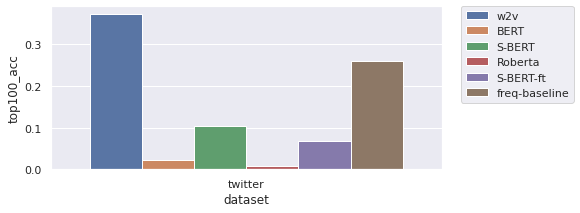

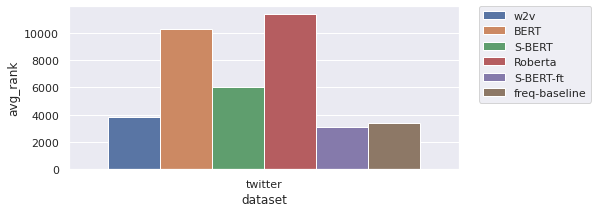

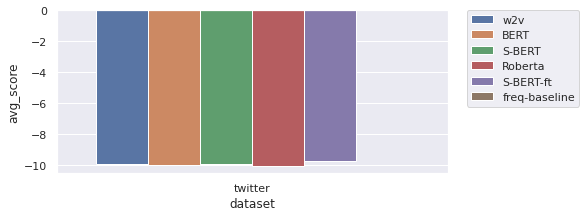

In [17]:
import seaborn as sns

sns.set_theme()

import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'model': [
        'w2v',
        'BERT',
        'S-BERT',
        'Roberta',
        'S-BERT-ft',
        'freq-baseline'
    ],
    'dataset': [
        'twitter',
        'twitter',
        'twitter',
        'twitter',
        'twitter',
        'twitter',
    ],
    'avg_rank': [
        twitter_w2v_negsample_avgrank, 
        twitter_bert_avg_rank,
        twitter_sbert_avg_rank,
        twitter_roberta_avg_rank,
        twitter_sbertft_avg_rank,
        twitter_freq_based_avg_rank,
    ],
    'avg_score': [
        twitter_w2v_negsample_avgscore, 
        twitter_bert_avg_score,
        twitter_sbert_avg_score,
        twitter_roberta_avg_score,
        twitter_sbertft_avg_score,
        None,
    ],
    'top100_acc': [
        twitter_w2v_negsample_top100acc,
        twitter_bert_top100acc,
        twitter_sbert_top100acc,
        twitter_roberta_top100acc,
        twitter_sbertft_top100acc,
        twitter_freq_based_top100acc,
    ],
})

df.to_csv('fixed_target_results_twitter_only_freq100.csv', header=True, index=False)

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='top100_acc', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='avg_rank', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='avg_score', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

### twitter vs wiki - projection

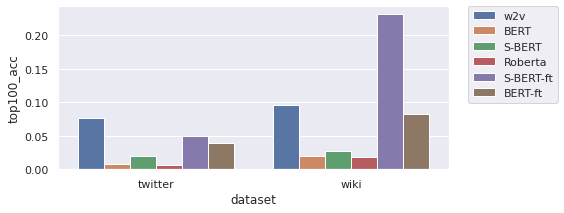

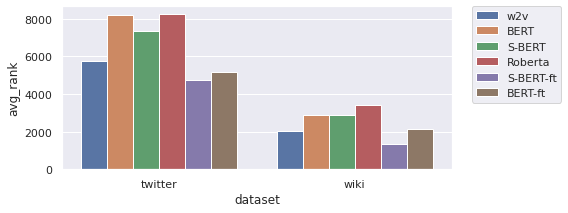

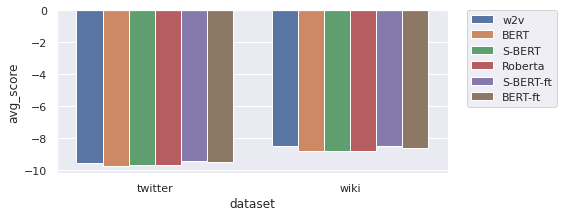

In [81]:
twitter_w2v_prj_avg_rank, twitter_w2v_prj_top100acc, twitter_w2v_prj_avg_score

import seaborn as sns

sns.set_theme()

import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'model': [
        'w2v',
        'w2v',
        'BERT',
        'BERT',
        'S-BERT',
        'S-BERT',
        'Roberta',
        'Roberta',
        'S-BERT-ft',
        'S-BERT-ft',
        'BERT-ft',
        'BERT-ft'
    ],
    'dataset': [
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
    ],
    'avg_rank': [
        twitter_w2v_prj_avg_rank, 
        wiki_w2v_prj_avg_rank,
        twitter_bert_prj_avg_rank, 
        wiki_bert_prj_avg_rank,
        twitter_sbert_prj_avg_rank, 
        wiki_sbert_prj_avg_rank,
        twitter_roberta_prj_avg_rank, 
        wiki_roberta_prj_avg_rank,
        twitter_sbertft_prj_avg_rank, 
        wiki_sbertft_prj_avg_rank,
        twitter_bertft_prj_avg_rank, 
        wiki_bertft_prj_avg_rank,
    ],
    'avg_score': [
        twitter_w2v_prj_avg_score, 
        wiki_w2v_prj_avg_score,
        twitter_bert_prj_avg_score, 
        wiki_bert_prj_avg_score,
        twitter_sbert_prj_avg_score, 
        wiki_sbert_prj_avg_score,
        twitter_roberta_prj_avg_score,
        wiki_roberta_prj_avg_score,
        twitter_sbertft_prj_avg_score, 
        wiki_sbertft_prj_avg_score,
        twitter_bertft_prj_avg_score, 
        wiki_bertft_prj_avg_score,
    ],
    'top100_acc': [
        twitter_w2v_prj_top100acc, 
        wiki_w2v_prj_top100acc,
        twitter_bert_prj_top100acc, 
        wiki_bert_prj_top100acc,
        twitter_sbert_prj_top100acc, 
        wiki_sbert_prj_top100acc,
        twitter_roberta_prj_top100acc,
        wiki_roberta_prj_top100acc,
        twitter_sbertft_prj_top100acc, 
        wiki_sbertft_prj_top100acc,
        twitter_bertft_prj_top100acc, 
        wiki_bertft_prj_top100acc,
    ],
})

df.to_csv('projection_final_results.csv', header=True, index=False)

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='top100_acc', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='avg_rank', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='avg_score', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

### twitter vs wiki

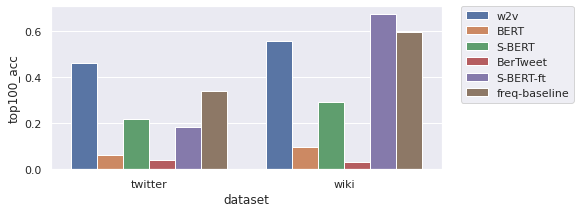

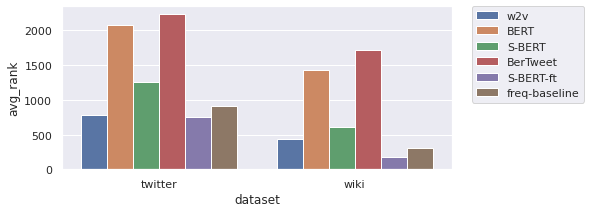

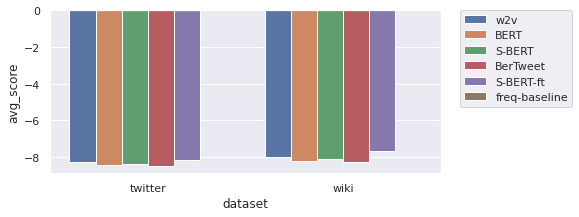

In [42]:
import seaborn as sns

sns.set_theme()

import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'model': [
        'w2v',
        'w2v',
        'BERT',
        'BERT',
        'S-BERT',
        'S-BERT',
        'BerTweet',
        'BerTweet',
        'S-BERT-ft',
        'S-BERT-ft',
        'freq-baseline',
        'freq-baseline'
    ],
    'dataset': [
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
    ],
    'avg_rank': [
        twitter_w2v_negsample_avgrank, 
        wiki_w2v_cbow_avgrank,
        twitter_bert_avg_rank,
        wiki_bert_avg_rank,
        twitter_sbert_avg_rank,
        wiki_sbert_avg_rank,
        twitter_bertweet_avg_rank,
        wiki_bertweet_avg_rank,
        twitter_sbertft_avg_rank,
        wiki_sbertft_avg_rank,
        twitter_freq_based_avg_rank,
        wiki_freq_based_avg_rank,
    ],
    'avg_score': [
        twitter_w2v_negsample_avgscore, 
        wiki_w2v_cbow_avgscore,
        twitter_bert_avg_score,
        wiki_bert_avg_score,
        twitter_sbert_avg_score,
        wiki_sbert_avg_score,
        twitter_bertweet_avg_score,
        wiki_bertweet_avg_score,
        twitter_sbertft_avg_score,
        wiki_sbertft_avg_score,
        None,
        None,
    ],
    'top100_acc': [
        twitter_w2v_negsample_top100acc,
        wiki_w2v_cbow_top100acc,
        twitter_bert_top100acc,
        wiki_bert_top100acc,
        twitter_sbert_top100acc,
        wiki_sbert_top100acc,
        twitter_bertweet_top100acc,
        wiki_bertweet_top100acc,
        twitter_sbertft_top100acc,
        wiki_sbertft_top100acc,
        twitter_freq_based_top100acc,
        wiki_freq_based_top100acc
    ],
})

df.to_csv('fixed_target_results.csv', header=True, index=False)

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='top100_acc', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='avg_rank', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='avg_score', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [45]:
(        twitter_w2v_negsample_avgscore, 
        twitter_bert_avg_score,
        twitter_sbert_avg_score,
        twitter_bertweet_avg_score,
        twitter_sbertft_avg_score,
), (

        wiki_w2v_cbow_avgscore,
        wiki_bert_avg_score,
        wiki_sbert_avg_score,
        wiki_bertweet_avg_score,
        wiki_sbertft_avg_score,
)

((-8.279070854187012,
  -8.453959465026855,
  -8.379989624023438,
  -8.46589183807373,
  -8.152100563049316),
 (-7.998246192932129,
  -8.239590644836426,
  -8.115586280822754,
  -8.26986026763916,
  -7.675154209136963))

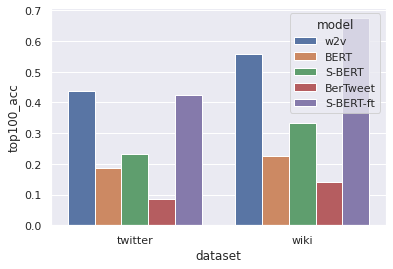

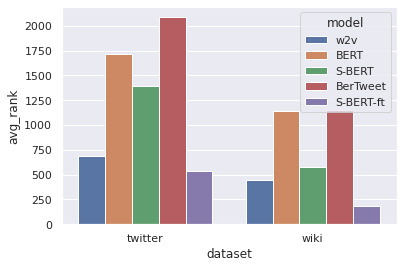

In [36]:
import seaborn as sns

sns.set_theme()

import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'model': [
        'w2v',
        'w2v',
        'BERT',
        'BERT',
        'S-BERT',
        'S-BERT',
        'BerTweet',
        'BerTweet',
        'S-BERT-ft',
        'S-BERT-ft',
    ],
    'dataset': [
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
    ],
    'avg_rank': [
        twitterrand_w2v_negsample_avgrank,
        wiki_w2v_cbow_avgrank,
        wikirand_w2v_cbow_avgrank,
        twitterrand_bert_avg_rank,
        wikirand_bert_avg_rank,
        twitterrand_sbert_avg_rank,
        wikirand_sbert_avg_rank,
        twitterrand_bertweet_avg_rank,
        wikirand_bertweet_avg_rank,
        twitterrand_sbertft_avg_rank,
        wikirand_sbertft_avg_rank,
    ],
    'top100_acc': [
        twitterrand_w2v_negsample_top100acc,
        wiki_w2v_cbow_top100acc
        wikirand_w2v_cbow_top100acc,
        twitterrand_bert_top100acc,
        wikirand_bert_top100acc,
        twitterrand_sbert_top100acc,
        wikirand_sbert_top100acc,
        twitterrand_bertweet_top100acc,
        wikirand_bertweet_top100acc,
        twitterrand_sbertft_top100acc,
        wikirand_sbertft_top100acc,
    ],
})

df.to_csv('result_restricted_randombio.csv', header=True, index=False)

sns.barplot(data=df, x='dataset', y='top100_acc', hue='model')
plt.show()

sns.barplot(data=df, x='dataset', y='avg_rank', hue='model')
plt.show()

### restricted target results

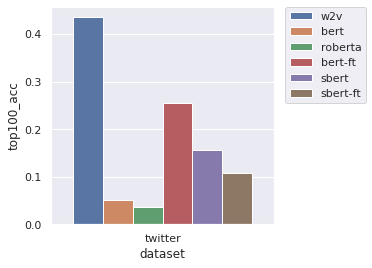

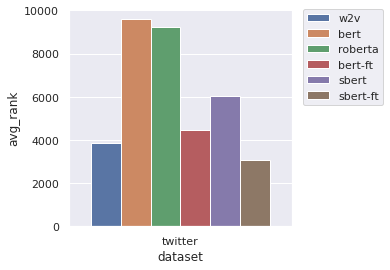

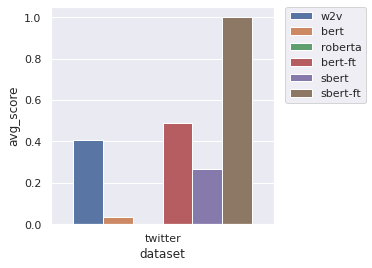

In [50]:
import seaborn as sns

sns.set_theme()

import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'model': [
        'w2v',
        'bert',
        'roberta',
        'bert-ft',
        'sbert',
        'sbert-ft'
    ],
    'dataset': [
        'twitter',
        'twitter',
        'twitter',
        'twitter',
        'twitter',
        'twitter',
    ],
    'avg_rank': [
        twitter_w2v_negsample_avgrank, 
        twitter_bert_avg_rank,
        twitter_roberta_avg_rank,
        twitter_bertft_avg_rank,
        twitter_sbert_avg_rank,
        twitter_sbertft_avg_rank,
    ],
    'avg_score': [
        twitter_w2v_negsample_avgscore, 
        twitter_bert_avg_score,
        twitter_roberta_avg_score,
        twitter_bertft_avg_score,
        twitter_sbert_avg_score,
        twitter_sbertft_avg_score,
    ],
    'top100_acc': [
        twitter_w2v_negsample_top100acc, 
        twitter_bert_top100acc,
        twitter_roberta_top100acc,
        twitter_bertft_top100acc,
        twitter_sbert_top100acc,
        twitter_sbertft_top100acc,
    ],
})

df.to_csv('twitter_final_results.csv', header=True, index=False)

plt.figure(figsize=(4,4))
sns.barplot(data=df, x='dataset', y='top100_acc', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

plt.figure(figsize=(4,4))
sns.barplot(data=df, x='dataset', y='avg_rank', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()


df['avg_score'] = (df['avg_score'] - min(df['avg_score'])) / (max(df['avg_score']) - min(df['avg_score']))
plt.figure(figsize=(4,4))
sns.barplot(data=df, x='dataset', y='avg_score', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

### restricted target results for wiki

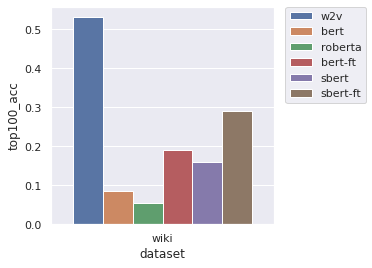

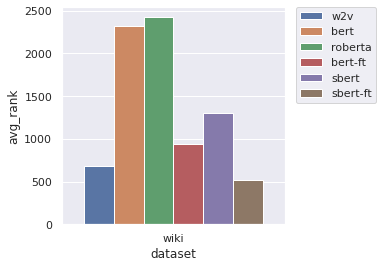

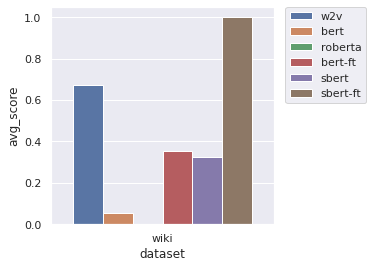

In [51]:
import seaborn as sns

sns.set_theme()

import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'model': [
        'w2v',
        'bert',
        'roberta',
        'bert-ft',
        'sbert',
        'sbert-ft'
    ],
    'dataset': [
        'wiki',
        'wiki',
        'wiki',
        'wiki',
        'wiki',
        'wiki',
    ],
    'avg_rank': [
        wiki_w2v_cbow_avgrank, 
        wiki_bert_avg_rank,
        wiki_roberta_avg_rank,
        wiki_bertft_avg_rank,
        wiki_sbert_avg_rank,
        wiki_sbertft_avg_rank,
    ],
    'avg_score': [
        wiki_w2v_cbow_avgscore, 
        wiki_bert_avg_score,
        wiki_roberta_avg_score,
        wiki_bertft_avg_score,
        wiki_sbert_avg_score,
        wiki_sbertft_avg_score,
    ],
    'top100_acc': [
        wiki_w2v_cbow_top100acc, 
        wiki_bert_top100acc,
        wiki_roberta_top100acc,
        wiki_bertft_top100acc,
        wiki_sbert_top100acc,
        wiki_sbertft_top100acc,
    ],
})

df.to_csv('wiki_final_results.csv', header=True, index=False)

plt.figure(figsize=(4,4))
sns.barplot(data=df, x='dataset', y='top100_acc', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

plt.figure(figsize=(4,4))
sns.barplot(data=df, x='dataset', y='avg_rank', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()


df['avg_score'] = (df['avg_score'] - min(df['avg_score'])) / (max(df['avg_score']) - min(df['avg_score']))
plt.figure(figsize=(4,4))
sns.barplot(data=df, x='dataset', y='avg_score', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

## freq vs ranks

In [25]:
import pickle

with open('data/twitter_cleaned_train_bios_100.pkl', 'rb') as f:
    twitter_bios = pickle.load(f)

twitter_cntr = Counter()

_, twitter_ys = zip(*fixed_target_twitter_clm_ds)
y_set = set(twitter_ys)

for bio in tqdm(twitter_bios):
    for pi in bio:
        if pi in y_set:
            twitter_cntr.update([pi])

    
with open('data/wiki_cleaned_train_bios_3.pkl', 'rb') as f:
    wiki_bios = pickle.load(f)
    
wiki_cntr = Counter()

_, wiki_ys = zip(*fixed_target_wiki_clm_ds)
y_set = set(wiki_ys)

for bio in tqdm(wiki_bios):
    for pi in bio:
        if pi in y_set:
            wiki_cntr.update([pi])

100%|██████████| 239046/239046 [00:00<00:00, 398803.70it/s]


In [26]:
import seaborn as sns
import numpy as np

sns.set_theme()

def plot_rank_freq(ranks, ys, name, order=1):
    if isinstance(ranks[0], list):
        ranks = [r[0] for r in ranks]
    
    data = np.array(list(zip(ranks, ys)))
    sample_ids = np.random.randint(0, len(ranks), size=10000)
    
    data = list(data[sample_ids])
    ranks, ys = zip(*data)
    
    freqs = []
    for y in ys:
        freqs.append(cntr[y]/100)

    ranks = [float(r) for r in ranks]
        
#     print(ranks[:3], freqs[:3])
#     print("plotting")
    
    sns.regplot(x=freqs, y=ranks, scatter=False, order=order, label=name)
    plt.xlabel('frequency')
    plt.ylabel('rank')
    plt.title('frequency vs rank for different models')
    
        


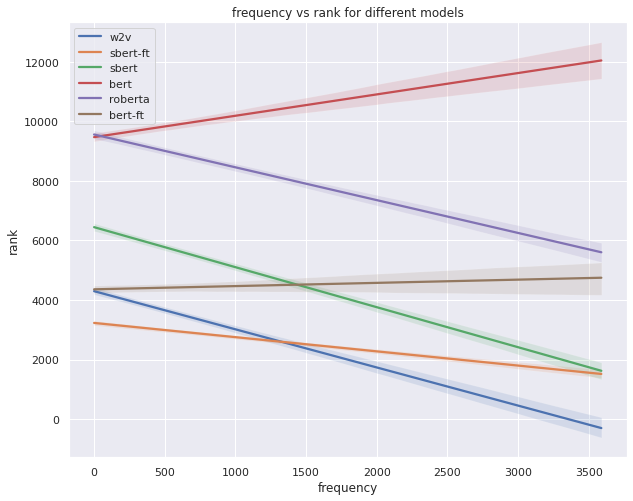

In [27]:
plt.figure(figsize=(10,8))
plot_rank_freq(twitter_w2v_negsample_ranks, twitter_ys, 'w2v', order=1)
plot_rank_freq(twitter_sbertft_ranks, twitter_ys, 'sbert-ft', order=1)
plot_rank_freq(twitter_sbert_ranks, twitter_ys, 'sbert')
plot_rank_freq(twitter_bert_ranks, twitter_ys, 'bert')
plot_rank_freq(twitter_roberta_ranks, twitter_ys, 'roberta')
plot_rank_freq(twitter_bertft_ranks, twitter_ys, 'bert-ft')
plt.legend()
plt.show()

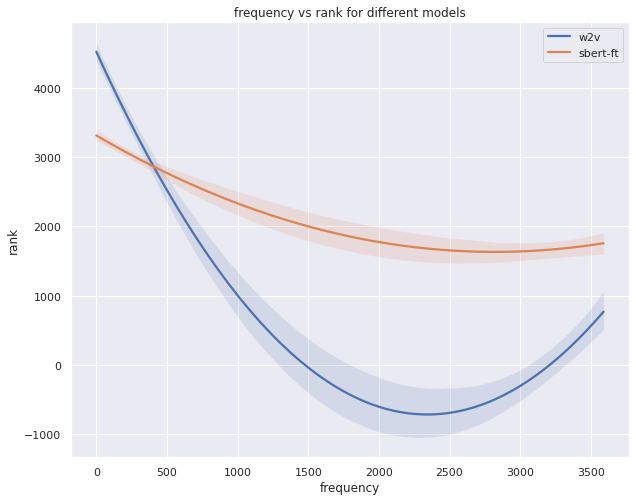

In [29]:
plt.figure(figsize=(10,8))
plot_rank_freq(twitter_w2v_negsample_ranks, twitter_ys, 'w2v', order=2)
plot_rank_freq(twitter_sbertft_ranks, twitter_ys, 'sbert-ft', order=2)
plt.legend()
plt.show()

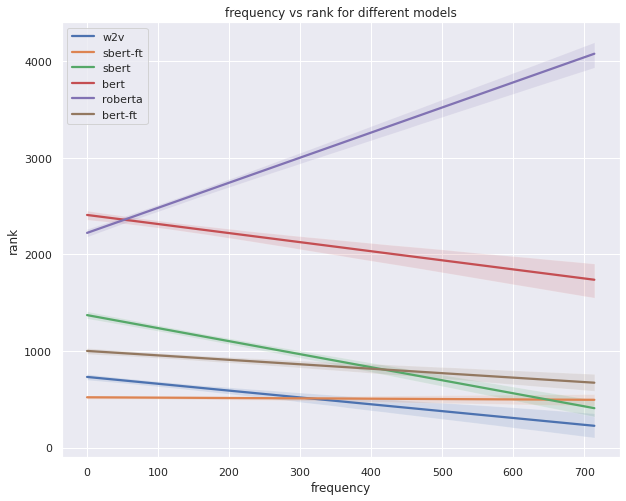

In [30]:
plt.figure(figsize=(10,8))
plot_rank_freq(wiki_w2v_cbow_ranks, wiki_ys, 'w2v', order=1)
plot_rank_freq(wiki_sbertft_ranks, wiki_ys, 'sbert-ft', order=1)
plot_rank_freq(wiki_sbert_ranks, wiki_ys, 'sbert')
plot_rank_freq(wiki_bert_ranks, wiki_ys, 'bert')
plot_rank_freq(wiki_roberta_ranks, wiki_ys, 'roberta')
plot_rank_freq(wiki_bertft_ranks, wiki_ys, 'bert-ft')
plt.legend()
plt.show()

# per sample comparison - top samples

## worst samples of each model

In [55]:
from sentence_transformers import SentenceTransformer, models, util

def get_worst_ranks(xs, ys, ranks, other_ranks_dict, name='default', topk=1000):
    if isinstance(ranks[0], list):
        ranks = [r[0] for r in ranks]
    ids = list(range(len(ranks)))
    
    ds_ranks = zip(ids, xs, ys, ranks)
    sorted_ds = sorted(ds_ranks, key=lambda x: -x[3])[:topk]
    
    ids, xs, ys, ranks = zip(*sorted_ds)
    
    rank_names = []
    other_ranks_list = []

    for rank_name, other_rank in other_ranks_dict.items():
        rank_names.append(rank_name)
        r = []
        for i in ids:
            r.append(other_rank[i])
        other_ranks_list.append(r)

    other_ranks_dict = {}
    for rank_name, rank in zip(rank_names, other_ranks_list):
        other_ranks_dict[rank_name] = rank
    
    df = pd.DataFrame({
        'bio': xs,
        'target': ys,
        f'{name}_rank': ranks,
        **other_ranks_dict
    })
    
    df.to_csv(f'{name}.csv', index=False, header=True)
    
    return ranks
    
    
    
all_ranks = {
    'w2v': [r[0] for r in twitter_w2v_negsample_ranks],
    'bert-ft': [r[0] for r in twitter_bertft_ranks],
    'sbert-ft': [r[0] for r in twitter_sbert_ranks]
}

xs, ys = zip(*fixed_target_twitter_clm_ds)
get_worst_ranks(xs, ys, twitter_w2v_negsample_ranks,
                other_ranks_dict= {k:v for k,v in all_ranks.items() if k != 'w2v'},
                name='w2v')
get_worst_ranks(xs, ys, twitter_bertft_ranks,
                other_ranks_dict= {k:v for k,v in all_ranks.items() if k != 'bert-ft'},
                name='bert-ft')
_ = get_worst_ranks(xs, ys, twitter_sbertft_ranks,
                other_ranks_dict= {k:v for k,v in all_ranks.items() if k != 'sbert-ft'},
                name='sbert-ft')



## load best rankings for w2v and fine-tuned model on twitter

In [42]:
from sentence_transformers import SentenceTransformer, models, util

def get_topk_ranks(w2v_model, x, y ,pi_dict, device='cpu', k=50):
    pi_list = list(pi_dict.keys())
    inv_dict = {v:k for k,v in pi_dict.items()}
    
    emb_x = torch.tensor([w2v_model.wv.get_mean_vector(x),], device=device)
    emb_all = torch.tensor([w2v_model.wv.get_vector(x) for x in pi_list], device=device)
    
    i = 0

    cosine_scores = util.cos_sim(emb_x, emb_all)
    ranks = torch.argsort(cosine_scores, dim=1, descending=True)
    rankranks = torch.argsort(ranks, dim=1)
    
    top_idxs = ranks[0,:k].tolist()
    top_pis = [inv_dict[i] for i in top_idxs]
    target_idx = torch.tensor([pi_dict[y]], dtype=torch.int64)
    target_rank = torch.gather(rankranks, 1, target_idx.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor).tolist()[0][0]

    return target_rank, top_pis



get_topk_ranks(
    w2v_twitter_negsamp_model,
    x=['dsd', 'xxxxxx', 'sd;flskdf;'],
    y='maga',
    pi_dict=twitter_pi_dict,
)


(3147.0,
 ['larry',
  'arsenal fc',
  'savemyanmar',
  's s',
  'rise',
  'god bless america',
  'heritage',
  'digital marketing',
  'prof',
  'columnist',
  'communist',
  'fuck it',
  'so much more',
  'freedom of speech',
  '33',
  'red velvet',
  '100% follow back',
  'blink',
  'husband to',
  'kc',
  'pilot',
  'chenle',
  'supporting',
  'michigan',
  'chiefskingdom',
  'chair',
  'ua',
  'star',
  'gym rat',
  'packers',
  'online',
  'pussy',
  'pfp made by',
  'sr',
  'all views',
  'army forever',
  'netflix',
  'bds',
  'got7',
  'cd',
  '1a',
  'bts_twt',
  'intelligent',
  'christian',
  'bh',
  'kpop stan',
  'resistor',
  'many more',
  'president trump',
  'editor-in-chief'])

In [ ]:
random_ids = np.random.randint(0, len(fixed_target_twitter_clm_ds), 100)

sample = [fixed_target_twitter_clm_ds[i] for i in random_ids]

for i, s in zip(random_ids, sample):
    r_w2v, _ = get_topk_ranks(
        w2v_twitter_negsamp_model,
        x=s[0],
        y=s[1],
        pi_dict=twitter_target_restricted_pis,
        wv=True
    )
    
    r_sbertft, _ = get_topk_ranks(
        twitter_ft_sbert,
        x=s[0],
        y=s[1],
        pi_dict=twitter_target_restricted_pis,
        wv=False
    )
    
    if r_sbertft > r_w2v + 1000:
        print(f"index:{i} w2vscore:{r_w2v}  sbert_ft score:{r_sbertft}")
        print("*"*100)
        print(s[0], "--->", s[1])
        print("*"*100)
    
    

256it [00:00, 27368.33it/s]          
256it [00:00, 27869.13it/s]          
256it [00:00, 28348.12it/s]          
256it [00:00, 28445.00it/s]          
256it [00:00, 28488.77it/s]          
256it [00:00, 28617.09it/s]          


([0, 1, 2], [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

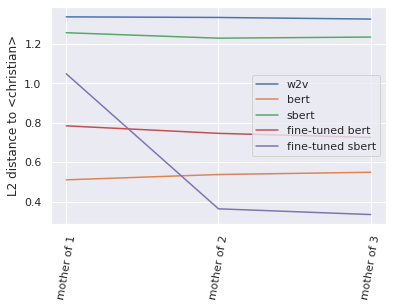

In [49]:
from numpy.linalg import norm as np_norm
import matplotlib.pyplot as plt
    
    
bertft100_dists = []
sbertft100_dists = []
sbert_dists = []
w2v_dists = []
bert_dists = []


def diff_norm(x1, x2):
    x1n = x1 / np_norm(x1)
    x2n = x2 / np_norm(x2)
    return np_norm(x1n-x2n)

for i in range(1, 4):
    sbert_dists.append(diff_norm(sbert_model.encode(f'mother of {i}'), sbert_model.encode('christian')))
    
    bert_emb = get_results_batched(bert_model, bert_tokenizer, [f'mother of {i}', 'christian']).numpy()
    bert_dists.append(diff_norm(bert_emb[0], bert_emb[1]))
    
    sbertft100_dists.append(diff_norm(twitter_ft_sbert.encode(f'mother of {i}'), twitter_ft_sbert.encode('christian')))
    
    bert_emb = get_results_batched(bert_ft_twitter_model, bert_tokenizer, [f'mother of {i}', 'christian']).numpy()
    bertft100_dists.append(diff_norm(bert_emb[0], bert_emb[1]))

    w2v_dists.append(diff_norm(w2v_twitter_negsamp_model.wv.get_mean_vector([f'mother of {i}']), w2v_twitter_negsamp_model.wv.get_vector('christian')))




xs = [f'mother of {i}' for i in range(1,4)]
sns.lineplot(x=xs, y=w2v_dists, label='w2v')
sns.lineplot(x=xs, y=bert_dists, label='bert')
sns.lineplot(x=xs, y=sbert_dists, label='sbert')
sns.lineplot(x=xs, y=bertft100_dists, label='fine-tuned bert')
sns.lineplot(x=xs, y=sbertft100_dists, label='fine-tuned sbert')
plt.ylabel("L2 distance to <christian>")
plt.xticks(rotation=80)

256it [00:00, 27605.46it/s]          
256it [00:00, 27861.18it/s]          
/scratch/12775300/ipykernel_14336/330388022.py:13: RuntimeWarning: invalid value encountered in true_divide
  x1n = x1 / np_norm(x1)
256it [00:00, 28792.05it/s]          
256it [00:00, 28411.88it/s]          
256it [00:00, 28833.80it/s]          
256it [00:00, 28586.61it/s]          


([0, 1, 2], [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

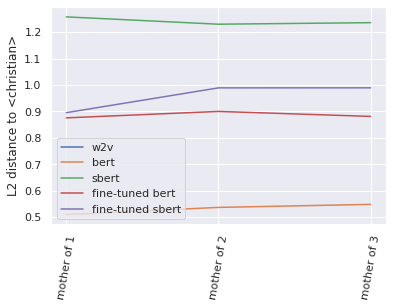

In [44]:
from numpy.linalg import norm as np_norm
import matplotlib.pyplot as plt
    
    
bertft100_dists = []
sbertft100_dists = []
sbert_dists = []
w2v_dists = []
bert_dists = []


def diff_norm(x1, x2):
    x1n = x1 / np_norm(x1)
    x2n = x2 / np_norm(x2)
    return np_norm(x1n-x2n)

for i in range(1, 4):
    sbert_dists.append(diff_norm(sbert_model.encode(f'mother of {i}'), sbert_model.encode('christian')))
    
    bert_emb = get_results_batched(bert_model, bert_tokenizer, [f'mother of {i}', 'christian']).numpy()
    bert_dists.append(diff_norm(bert_emb[0], bert_emb[1]))
    
    sbertft100_dists.append(diff_norm(wiki_ft_sbert.encode(f'mother of {i}'), wiki_ft_sbert.encode('christian')))
    
    bert_emb = get_results_batched(bert_ft_wiki_model, bert_tokenizer, [f'mother of {i}', 'christian']).numpy()
    bertft100_dists.append(diff_norm(bert_emb[0], bert_emb[1]))

    w2v_dists.append(diff_norm(w2v_wiki_cbow_model.wv.get_mean_vector([f'mother of {i}']), w2v_wiki_cbow_model.wv.get_vector('christian')))

xs = [f'mother of {i}' for i in range(1,4)]
sns.lineplot(x=xs, y=w2v_dists, label='w2v')
sns.lineplot(x=xs, y=bert_dists, label='bert')
sns.lineplot(x=xs, y=sbert_dists, label='sbert')
sns.lineplot(x=xs, y=bertft100_dists, label='fine-tuned bert')
sns.lineplot(x=xs, y=sbertft100_dists, label='fine-tuned sbert')
plt.ylabel("L2 distance to <christian>")
plt.xticks(rotation=80)

# build survey questions

## neighborhood score + negative sampling choices

In [ ]:
import pandas as pd
from ast import literal_eval

df = pd.read_csv('twitter_pi_with_neighbors_tfidf.csv')
print(df.head())
df.positives = df.positives.apply(literal_eval)
df.negatives = df.negatives.apply(literal_eval)

In [ ]:
from tqdm import tqdm
from random import randint

pis = df['pis']
positives = df['positives']
negatives = df['negatives']

sample_cnt = 500
questions = []
targets = []
other_choices = []

sample_idices = np.random.randint(0, len(df), size=sample_cnt)

for qid in sample_idices:
    q = pis[qid]
    cur_pos = positives[qid]
    cur_neg = negatives[qid]
    target = cur_pos[randint(0,len(cur_pos)-1)]
    targets.append(target)
    questions.append(q)
    other_choices.append(np.random.choice(cur_neg, size=3, replace=False))
    
res = pd.DataFrame({'question_pi': questions, 'ans_pi': targets, 'other_choices': other_choices})
res.to_csv('surrvey_tfidf_twitter.csv', index=False, header=True)

In [ ]:
!head surrvey_tfidf_twitter.csv -n 100

## model based question generation

In [ ]:
from sentence_transformers import SentenceTransformer, models, util

fint_model = SentenceTransformer('./models/miniLM-L6-finetuned/')

In [ ]:
from tqdm import tqdm
from random import randint


all_pis = df['pis']
sims = df['similars']
sample_cnt = 500

questions = []
targets = []
other_choices = []

i = 0
while i < sample_cnt:
    idx = randint(0, len(all_pis)-1)
    questions.append(all_pis[idx])
    i += 1



In [ ]:
fint_emb_x = fint_model.encode(questions, convert_to_tensor=True)
fint_emb_all = fint_model.encode(all_pis, convert_to_tensor=True)


In [ ]:
import numpy as np

targets = []
other_choices = []

for x in tqdm(fint_emb_x):
    cosine_scores = util.cos_sim(x, fint_emb_all).detach().cpu().numpy()[0]
    argsort = np.argsort(cosine_scores)
    best_k = argsort[-6:-1]
    worst_k = argsort[:len(argsort)//2]
    
    target_idx = np.random.choice(best_k)
    targets.append(all_pis[target_idx])
    
    other_idxs = np.random.choice(worst_k, size=3, replace=False)
    other_choices.append([all_pis[x] for x in other_idxs])
    
    
res = pd.DataFrame({'question_pi': questions, 'ans_pi': targets, 'other_choices': other_choices})
res.to_csv('modelbased-selection.csv', index=False, header=True)
    

In [ ]:
!head modelbased-selection.csv